Выполнил: 
студент группы ПМ23-2 *Грингруз Д.М.* 

Научный руководитель: 
к.т.н, старший преподаватель *Миронов В.О.*

# Курсовая работа: *Оптимизация методов борьбы с перекосом классов в машинном обучении*

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc
from imblearn.pipeline import Pipeline
import optuna
from sklearn.cluster import KMeans
from optuna.samplers import TPESampler
import time

**Дисбаланс классов** - одна из самых распространенных проблем в машинном обучении. В случаях классификации - это ситуация, когда один целевой класс превосходит другой целевой класс в несколько десятков раз.

Дисбаланс классов присутствует во всех сферах деятельности: медицины, финансах, физики, рекомендательных системах и так далее.

Существует несколько основных методов борьбы с перекосом классов:

1. Изменение веса класса большинства
2. Увеличение выборки
3. Уменьшение выборки

Для своей курсовой работы я выбрал известный датасет, содержащий транзакции, совершенные держателями кредитных карт в сентябре 2013 года. В нем присутствуют мошеннические транзакции, которых естественно гораздо меньше, чем обычных.

Теоретические основы методов борьбы с перекосом классов
Классы в задачах классификации могут быть несбалансированные. Обучение моделей на таких данных приведет к игнорированию класса меньшинства, отдавая предпочтение классу большинства.

Методы уменьшения данных (Undersampling)

Random Undersampling уменьшает размер класса большинства до размера класса меньшинства путём случайного удаления части примеров из большого класса до доведения его до определенного баланса с меньшим классом.
NEARMISS выборочно удаляет примеры классы большинства, которые находятся вблизи класса меньшинства.
Tomek Links определяет пары близлежащих соседей, где один элемент представляет класс большинство, а другой — меньшинство. Затем из каждой пары удаляется образец, принадлежащий к большему классу.

Cluster Centroids группирует примеры класса большинства и заменяет их на центроиды кластеров. Таким образом выравнивается соотношение классов.

Методы увеличения данных (Oversampling)

Random oversampling увеличивает число примеров путём повторного использования данных до нужного соотношения классов.

Synthetic Minority Over-sampling Technique (SMOTE) генерирует данные путём нахождения K ближайших соседей, выбора одной из них и создания новой точки. Весь этот процесс повторяется до достижения баланса между классами.

Adaptive Synthetic (ADASYN) оценивает для каждого примера из класса меньшинства, насколько сложно его классифицировать путём определения количества соседей. Метод определяет вес для каждого примера из класса меньшинства, а затем генерирует синтетические данные для тех представителей класса меньшинства, которых сложнее всего классифицировать.


**Цель:** оптимизировать методы борьбы с перекосом классов.

**Задачи:**

    1. Провести описательный анализ датасета (EDA).
    2. Провести предварительную обработку данных (Preprocessing DATA).
    3. Разделить данные на обучающую и тестовую выборки.
    4. обучить и выбрать лучшую модель машинного обучения без применения методов борьбы с перекосом классов.
    5. Применить методы борьбы с перекосом классов для выбранной модели на предыдущем шаге.
    6. Оптимизировать модель, используя библиотеку Optuna.
    7. Сформулировать выводы.

In [33]:
data = pd.read_csv('creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Датасет состоит из 31 столбца и 284807 строк.

Описание:

* **Time** - время (с) с начала эксперимента
* **V1-V28** - различные клиентские признаки, разложенные методом главных компонент для защиты конфиденциальных данных о клиенте 
* **Amount** = сумма транзакции
* **Class** - мошенническая транзакция (1) и не мошенническая транзакция (0)

Основная метрика в исследовании: **F1-Score**

Обычная точность (Accuracy) не подходит, так как из-за большого дисбаланса целевого класса метрика будет хорошо распознавать класс большинство, но плохо класс меньшинство. Из-за этого значение этой метрики будет почти всегда близка к 1.

## **Описательный анализ данных (EDA)**

### Первичный осмотр

Проверим тип данных для каждого из столбцов, наличие пропусков в датасете

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Каждый из столбцов в датасете имеет числовой тип. Пропусков нет. В наборе данных 284807 строк и 31 столбец.

### Статистическое описание данных

In [23]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


1. Признаки 'Time' и 'Amount' не нормализованы
2. Есть выброс или выбросы в 'Amount', так как максимальная сумма транзакции = 25691.16, а 75% перцентиль = 77.16
3. В анонимных признаках есть довольно большой размах между минимумом и максимумом
4. Очень сильный дисбаланс в целевой переменной 'Class', так как среднее значение mean = 0.001727 или 0,17% это мошеннеческие транзакции, а все остальное 99,83% - обычные
5. Есть хотя бы одна транзакция с нулевой суммой
6. Нет затаившихся пропусков, то есть, например, отрицательных значений в 'Time', 'Amount' и 'Class'.

Посмотрим на максимальную по сумме транзакцию:

In [27]:
data.loc[data['Amount'] ==  25691.160000]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.34736,-3.872425,...,-21.62012,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


Оказалась, что транзакция не мошеннеческая.

Посмотрим на транзакции с нулевой суммой

In [31]:
null_rows = data.loc[data['Amount'] == 0]
null_rows

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
383,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
514,380.0,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
534,403.0,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
575,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283719,171817.0,-0.750414,0.904175,0.996461,0.427284,1.720336,0.929256,0.794272,0.176719,-1.836261,...,0.050750,0.115532,-0.623995,-0.186896,0.733759,2.558151,-0.188835,0.001654,0.0,0
283782,171870.0,2.083677,-0.065811,-1.442870,0.135416,0.043035,-1.306975,0.335835,-0.371635,0.730560,...,-0.147536,-0.246599,0.194758,-0.082277,0.012887,-0.069278,-0.048995,-0.065482,0.0,0
283949,172027.0,2.132569,-0.057836,-1.724522,-0.030326,0.412146,-0.903088,0.345843,-0.348132,0.722638,...,-0.188739,-0.343876,0.105024,-0.763831,0.117381,-0.027682,-0.047514,-0.071700,0.0,0
284085,172140.0,-2.210521,-1.039425,0.189704,-1.291932,3.742120,-1.665061,3.120388,-2.324089,0.364926,...,-0.286359,1.326003,-0.361764,-0.268117,1.051309,0.334629,-1.930149,-0.899888,0.0,0


Получается, таких транзакций много и не все они мошеннические.

### Распределение переменных

Посмотрим на распределение целевой переменной

In [36]:
vc = data['Class'].value_counts()
vc

Class
0    284315
1       492
Name: count, dtype: int64

Не мошеннеческие транзакции - **284315**

Мошеннические транзакции - **492**

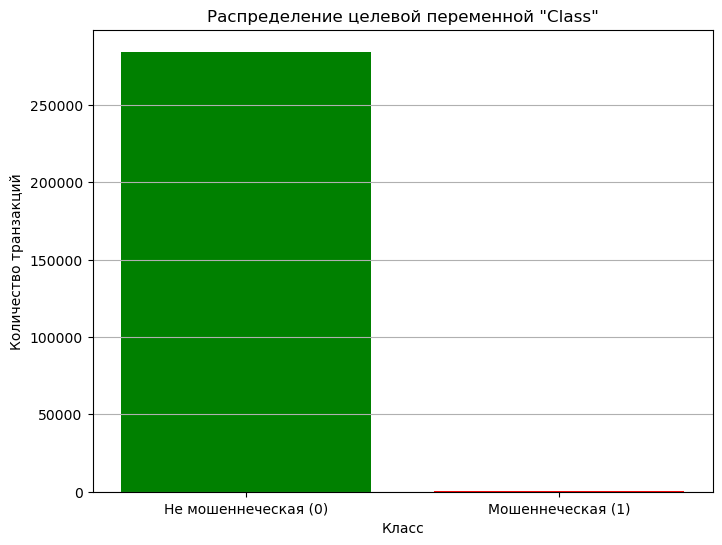

In [39]:
plt.figure(figsize=(8, 6))
plt.bar(vc.index, vc.values, tick_label=['Не мошеннеческая (0)', 'Мошеннеческая (1)'], color = ['g', 'r'])
plt.grid(axis = 'y')
plt.title('Распределение целевой переменной "Class"')
plt.xlabel('Класс')
plt.ylabel('Количество транзакций');

Дисбаланс подтвержден не только через статистику, но и через визуализацию с подсчётом количества каждого класса

Посмотрим на распределение признаков:

Посмотрим на распределение признаков 'Amount' и 'Time'

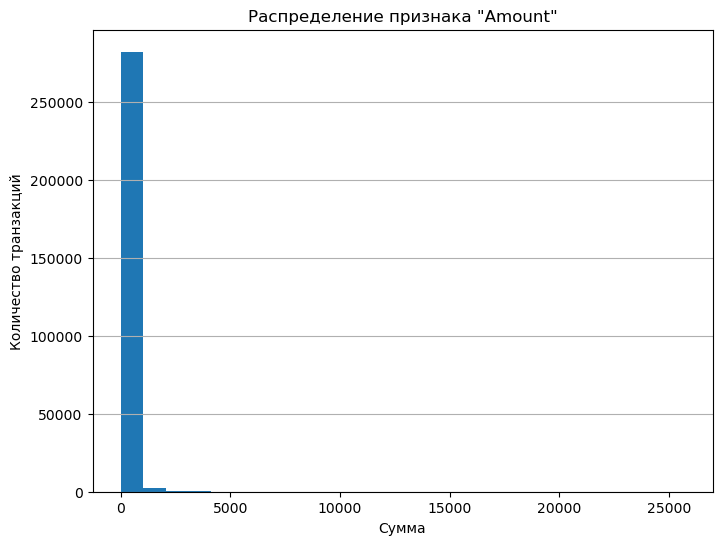

In [44]:
plt.figure(figsize=(8, 6))
plt.hist(data['Amount'], bins = 25)
plt.title('Распределение признака "Amount"')
plt.xlabel('Сумма')
plt.ylabel('Количество транзакций')
plt.grid(axis = 'y')
plt.show()

Видно, что почти все суммы платежей не превышают 5000. График построился так, что на нем есть не менее одного выброса, то есть значение около 25000.

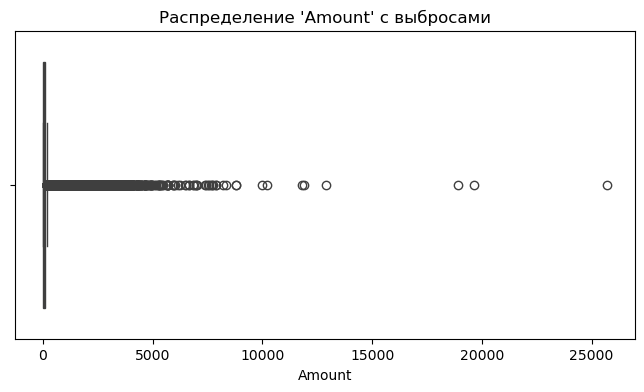

In [47]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data["Amount"])
plt.title("Распределение 'Amount' с выбросами")
plt.show()

Ящик с усами подтверждает наличие выбросов.

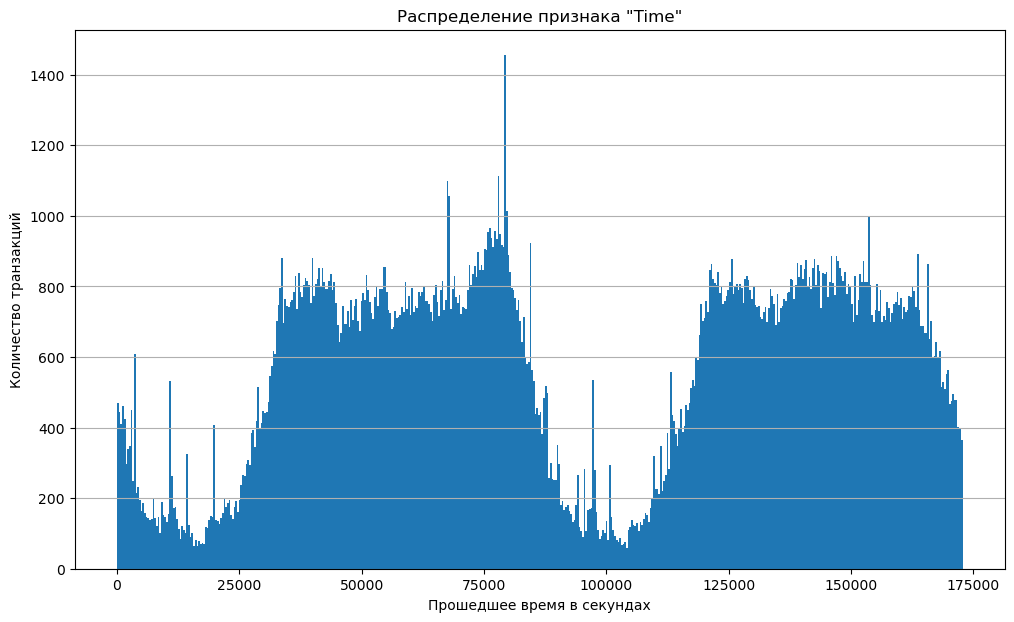

In [50]:
plt.figure(figsize=(12, 7))
plt.hist(data['Time'], bins = 500)
plt.title('Распределение признака "Time"')
plt.xlabel('Прошедшее время в секундах')
plt.ylabel('Количество транзакций')
plt.grid(axis = 'y')
plt.show()

Время в этом датасете означает количество секунд от начала эксперимента до момента транзакции. Ямки на графике - это скорее всего ночь, когда количество транзакций минимально. Форма распределения ненормальная.

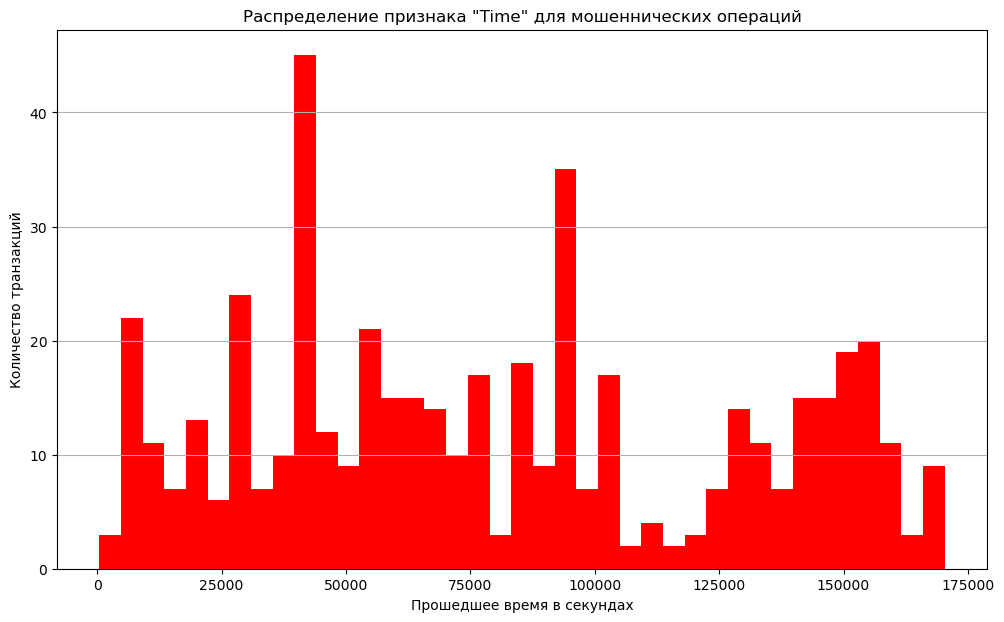

In [53]:
plt.figure(figsize=(12, 7))
plt.hist(data[data['Class'] == 1]['Time'], bins = 39, color = ['r'], alpha=1)
plt.title('Распределение признака "Time" для мошеннических операций')
plt.xlabel('Прошедшее время в секундах')
plt.ylabel('Количество транзакций')
plt.grid(axis = 'y')
plt.show()

Видимо мошеннические операции в основном происходят днём, потому что ночные ямки совпадают с общим датасетом. Мошенники хотят затеряться среди обычных клиентов.

### Корреляция признаков

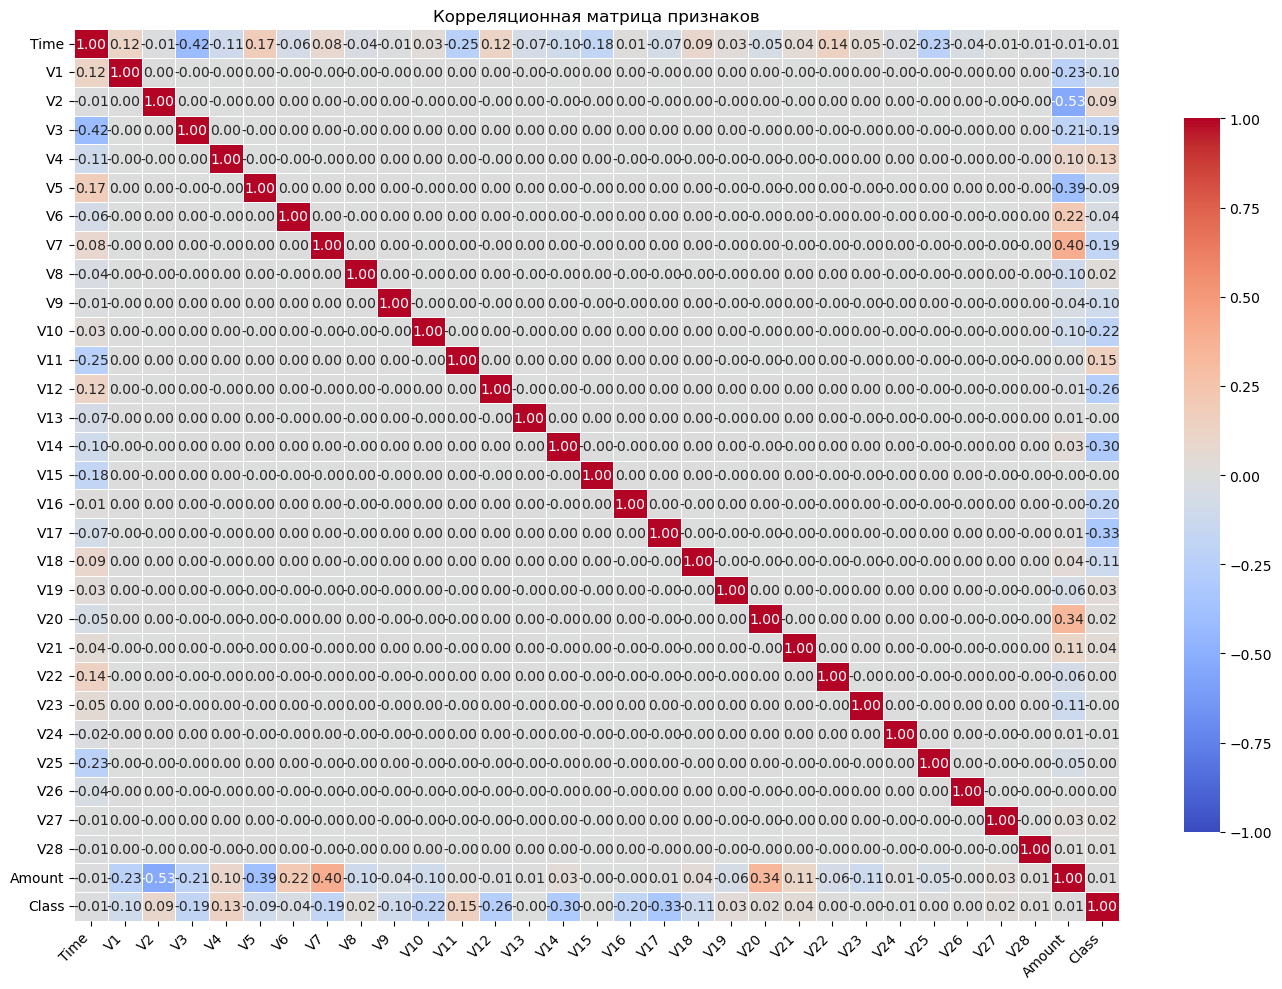

In [61]:
plt.figure(figsize=(14, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Корреляционная матрица признаков")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


Признаки V1-V28 никак между собой не коррелируют, так как они получены через метод главных компонент. Низкая мультиколлинеарность.

У целевой переменной 'Class' больше всего связь с признаками V1, V3, V4, V5, V9, V10, V11, V12, V14, V16, V17, V18. При этом все из перечисленных признаков имеют очень слабую корреляцию с 'Class', так как коэффициент корреляции меньше или равен 0,3. У V14 и V17 просто слабая отрицательная корреляция с целевой переменной.

В целом, из-за сильного дисбаланса у целевой переменной низкая корреляция его  с признаками.
Ни один из признаков V1-V28 удалять не будем. Потому что какие-то признаки слабо, но коррелируют с 'Time', другие - с 'Class' и 'Amount'.

## **Предварительная обработка данных (Preprocessing DATA)**

Поскольку V1-V28 получены через метод главных компонент (PCA), то ничего с ними делать не надо. Удалять какие-нибудь столбцы из них тоже нежелательно, так как можно потерять важные данные, поэтому я этого делать не буду. К тому же их среднее находится около 0, а стандартное отклонение около 1, то есть они уже стандартизированы.

На предыдущем этапе было обнаружено наличие выброса у переменной 'Amount', к тому же этот признак не нормирован, а это плохо, так как будут использоваться модели, которые чувствительны к выбросам, поэтому я его стандартизирую. Из-за формы распределения 'Time' будет применен робастный метод.

In [36]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


In [11]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.001727,0.927124,0.118914
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,3.495006,0.557903
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-0.307413,-0.994983
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,-0.229162,-0.358210
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,0.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,0.770838,0.641790
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,358.683155,1.035022


# **Моделирование**

## **Разделение данных**

In [38]:
X = data.drop(columns=['Class'])
y = data['Class']

Разделяем датасет на обучающую и тестовую выборку в соотношении 80/20. Устанавливаем random_state = 2025, чтобы зафиксировать случайность для проведения экспермиентов. Так как задача классификации с перекосом классов, стратифицируем разделение.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025, stratify=y)

In [43]:
print('Размерность набора данных X_train: ', X_train.shape)
print('Размерность набора данных y_train: ', y_train.shape)
print('Размерность набора данных X_test: ', X_test.shape)
print('Размерность набора данных y_test: ', y_test.shape)

Размерность набора данных X_train:  (227845, 30)
Размерность набора данных y_train:  (227845,)
Размерность набора данных X_test:  (56962, 30)
Размерность набора данных y_test:  (56962,)


Поскольку я собираюсь применять методы увеличения выборки и уменьшения, обязательно нужно применить кросс-валидацию к обучающей выборке, иначе возможна потеря данных, что в свою очередь скажется на качестве модели. Так как задача бинарной классификации, то в фолдах нужно сохранить пропрции классов.

In [46]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

## **Обучение моделей**

### Базовые модели

#### Логистическая регрессия

In [40]:
lregress = LogisticRegression()
scores = cross_val_score(lregress, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
lregress.fit(X_train, y_train)
train_time_lregress = time.perf_counter() - start_train
prediction_lregress = lregress.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_lregress))
print(f'Время обучения модели: {train_time_lregress} с')

Кросс-валидация F1 scores: [0.734375   0.73913043 0.68217054 0.70229008 0.74829932], Среднее: 0.721
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.61      0.71        98

    accuracy                           1.00     56962
   macro avg       0.93      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 0.3890607999637723 с


Среднее значение **F1-score** при кросс-валидации составило 0.721. Модель хорошая.

Есть разброс значений **F1-score** от 0.682 до 0.748. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.86 - модель ошибается в 14% случаев, предсказывая положительный класс.

* **Recall** = 0.61 - модель не видит 39% реальных положительных случаев.

* **F1-score** = 0.71

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 0.93, но это неправильно, так как основной вклад вносит класс большинства (0).

#### Метод k-ближайших соседей (KNN Classifier)

In [30]:
knn_model = KNeighborsClassifier()
scores = cross_val_score(knn_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
knn_model.fit(X_train, y_train)
train_time_knn = time.perf_counter() - start_train
prediction_knn = knn_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_knn))
print(f'Время обучения модели: {train_time_knn} с')

  File "D:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Кросс-валидация F1 scores: [0.76258993 0.91891892 0.80821918 0.84285714 0.8630137 ], Среднее: 0.839
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.77      0.87        98

    accuracy                           1.00     56962
   macro avg       1.00      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 0.03599849995225668 с


Среднее значение **F1-score** при кросс-валидации составило 0.839. Модель хорошая.

Есть разброс значений **F1-score** от 0.763 до 0.919. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 1.00.

* **Recall** = 0.77 - модель не видит 23% реальных положительных случаев.

* **F1-score** = 0.87

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

#### Метод опорных векторов (SVM)

In [33]:
svm_model = LinearSVC()
scores = cross_val_score(svm_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
svm_model.fit(X_train, y_train)
train_time_svm = time.perf_counter() - start_train
prediction_svm = svm_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_svm))
print(f'Время обучения модели: {train_time_svm} с')

Кросс-валидация F1 scores: [0.6969697  0.75555556 0.73529412 0.672      0.69767442], Среднее: 0.711
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.57      0.69        98

    accuracy                           1.00     56962
   macro avg       0.94      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 1.023712099995464 с


Среднее значение **F1-score** при кросс-валидации составило 0.711. Модель неплохая.

Есть разброс значений **F1-score** от 0.672 до 0.756. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.88 - модель ошибается в 12% случаев, предсказывая положительный класс.

* **Recall** = 0.57 - модель не видит 43% реальных положительных случаев.

* **F1-score** = 0.69

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

#### Наивный байесовский классификатор

In [37]:
naive_model = GaussianNB()
scores = cross_val_score(naive_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
naive_model.fit(X_train, y_train)
train_time_naive = time.perf_counter() - start_train
prediction_naive = naive_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_naive))
print(f'Время обучения модели: {train_time_naive} с')

Кросс-валидация F1 scores: [0.10981098 0.12115891 0.11836379 0.10862069 0.11063094], Среднее: 0.114
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.85      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Время обучения модели: 0.09624610003083944 с


Среднее значение **F1-score** при кросс-валидации составило 0.114. Модель плохая.

Есть разброс значений **F1-score** от 0.109 до 0.121. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны приблизительно 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.07 - модель ошибается в 93% случаев, предсказывая положительный класс.

* **Recall** = 0.85 - модель не видит 15% реальных положительных случаев.

* **F1-score** = 0.12

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 0.98, но это неправильно, так как основной вклад вносит класс большинства (0).

#### Дерево решений (Decision Tree)

In [40]:
decision_model = DecisionTreeClassifier()
scores = cross_val_score(decision_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
decision_model.fit(X_train, y_train)
train_time_decision = time.perf_counter() - start_train
prediction_decision = decision_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_decision))
print(f'Время обучения модели: {train_time_decision} с')

Кросс-валидация F1 scores: [0.70440252 0.76571429 0.76623377 0.76623377 0.78980892], Среднее: 0.758
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.80      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 15.982412499957718 с


Среднее значение **F1-score** при кросс-валидации составило 0.758. Модель хорошая.

Есть разброс значений **F1-score** от 0.704 до 0.790. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.80 - модель ошибается в 20% случаев, предсказывая положительный класс.

* **Recall** = 0.80 - модель не видит 20% реальных положительных случаев.

* **F1-score** = 0.80

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

### Ансамблевые модели

#### Бэггинг для дерева решений

In [44]:
bg_model = BaggingClassifier(DecisionTreeClassifier())
scores = cross_val_score(bg_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
bg_model.fit(X_train, y_train)
train_time_bg = time.perf_counter() - start_train
prediction_bg = bg_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_bg))
print(f'Время обучения модели: {train_time_bg} с')

Кросс-валидация F1 scores: [0.78014184 0.90540541 0.82993197 0.85314685 0.8630137 ], Среднее: 0.846
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.82      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 94.29952910006978 с


Среднее значение **F1-score** при кросс-валидации составило 0.846. Модель хорошая.

Есть разброс значений **F1-score** от 0.780 до 0.905. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.98 - модель ошибается в 2% случаев, предсказывая положительный класс.

* **Recall** = 0.82 - модель не видит 18% реальных положительных случаев.

* **F1-score** = 0.89

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

#### Бустинг (AdaBoostClassifier)

In [47]:
adb_model = AdaBoostClassifier(DecisionTreeClassifier())
scores = cross_val_score(adb_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
adb_model.fit(X_train, y_train)
train_time_adb = time.perf_counter() - start_train
prediction_adb = adb_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_adb))
print(f'Время обучения модели: {train_time_adb} с')

Кросс-валидация F1 scores: [0.74358974 0.74556213 0.77707006 0.75816993 0.73619632], Среднее: 0.752
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.79      0.79        98

    accuracy                           1.00     56962
   macro avg       0.89      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 17.42842190002557 с


Среднее значение **F1-score** при кросс-валидации составило 0.752. Модель неплохая.

Есть разброс значений **F1-score** от 0.736 до 0.777. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.79 - модель ошибается в 21% случаев, предсказывая положительный класс.

* **Recall** = 0.79 - модель не видит 21% реальных положительных случаев.

* **F1-score** = 0.79

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

Random Forest

In [23]:
rf_model = RandomForestClassifier()
scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='f1')
start_train = time.perf_counter()
rf_model.fit(X_train, y_train)
train_time_rf = time.perf_counter() - start_train
prediction_rf = rf_model.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_rf))
print(f'Время обучения модели: {train_time_rf} с')

Кросс-валидация F1 scores: [0.79411765 0.91891892 0.82993197 0.82014388 0.82993197], Среднее: 0.839
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.83      0.90        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 168.52947499998845 с


Среднее значение **F1-score** при кросс-валидации составило 0.839. Модель отличная.

Есть разброс значений **F1-score** от 0.794 до 0.919. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.99 - модель ошибается в 1% случаев, предсказывая положительный класс.

* **Recall** = 0.83 - модель не видит 17% реальных положительных случаев.

* **F1-score** = 0.90

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

In [73]:
model_predictions = {
    "LogisticRegression": prediction_lregress,
    "KNeighborsClassifier": prediction_knn,
    "LinearSVC": prediction_svm,
    "GaussianNB": prediction_naive,
    "DecisionTreeClassifier": prediction_decision,
    "BaggingClassifier": prediction_bg,
    "AdaBoostClassifier": prediction_adb,
    "RandomForestClassifier": prediction_rf
}

train_times = {
    "LogisticRegression": train_time_lregress,
    "KNeighborsClassifier": train_time_knn,
    "LinearSVC": train_time_svm,
    "GaussianNB": train_time_naive,
    "DecisionTreeClassifier": train_time_decision,
    "BaggingClassifier": train_time_bg,
    "AdaBoostClassifier": train_time_adb,
    "RandomForestClassifier": train_time_rf
}

results = []

for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    metrics = {
        "Модель": model_name,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
        "Время обучения (с)": train_times[model_name]
    }
    
    results.append(metrics)

data_results = pd.DataFrame(results)
data_results

,Модель,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,Время обучения (с)
0,LogisticRegression,0.999332,0.999824,0.999578,0.857143,0.612245,0.714286,0.999157,0.376878
1,KNeighborsClassifier,0.999596,1.000000,0.999798,1.000000,0.765306,0.867052,0.999596,0.035998
2,LinearSVC,0.999262,0.999859,0.999560,0.875000,0.571429,0.691358,0.999122,1.023712
3,GaussianNB,0.999731,0.979126,0.989321,0.065354,0.846939,0.121345,0.978898,0.096246
4,DecisionTreeClassifier,0.999648,0.999648,0.999648,0.795918,0.795918,0.795918,0.999298,15.982412
5,BaggingClassifier,0.999684,0.999965,0.999824,0.975610,0.816327,0.888889,0.999649,94.299529
6,AdaBoostClassifier,0.999631,0.999631,0.999631,0.785714,0.785714,0.785714,0.999263,17.428422
7,RandomForestClassifier,0.999684,0.999982,0.999833,0.987654,0.816327,0.893855,0.999666,163.936035


**Выводы по работе моделей**

1. Из-за сильного дисбаланса классов, **Accuracy** у всех моделей близка 1.00.
2. Лучшие модели по метрике F1: **BaggingClassifier**, **RandomForestClassifier**, **KNeighborsClassifier**.
3. Худшие модели: **GaussianNB**, **LinearSVC**
4. Самые быстрые модели: **KNeighborsClassifier**,  **GaussianNB**
5. Самые медленные модели: **RandomForestClassifier**, **BaggingClassifier**

Для достижения лучших метрик, используя методы борьбы с перекосом классов, для класса меньшинства будет выбрана модель Random Forest.

## Применение методов борьбы с перекосом классов

**Synthetic Minority Over-sampling Technique (SMOTE)**

In [52]:
rf_model_smote = RandomForestClassifier()
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_smote, X_smote, y_smote, cv=kf, scoring='f1',n_jobs=-1)
start_train = time.perf_counter()
rf_model_smote.fit(X_smote, y_smote)
train_time_smote = time.perf_counter() - start_train
prediction_smote = rf_model_smote.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_smote))
print(f'Время обучения модели: {train_time_smote} с')

Кросс-валидация F1 scores: [0.9998901  0.99993406 0.99985713 0.99987911 0.9998901 ], Среднее: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 284.86906810011715 с


Среднее значение **F1-score** при кросс-валидации составило 1.000. Модель отличная.

Есть разброс значений **F1-score** от 0.999 до 0.999. Модель стабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.89 - модель ошибается в 11% случаев, предсказывая положительный класс.

* **Recall** = 0.83 - модель не видит 17% реальных положительных случаев.

* **F1-score** = 0.86

Модель хорошо предсказывает большинство (0), но хуже класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

Заметный рост в метриках, особенно на кросс-валидации. **Recall** для класса меньшинства вырос по сравнению до применения метода **SMOTE**. Это значит, что модель меньше пропускает мошеннические транзакции. **Precision** немного снизился, значит модель больше ловит мошенничество, но чаще ошибается. Для банка это хорошо, так как их задача минимизировать мошеннеческие транзакции.

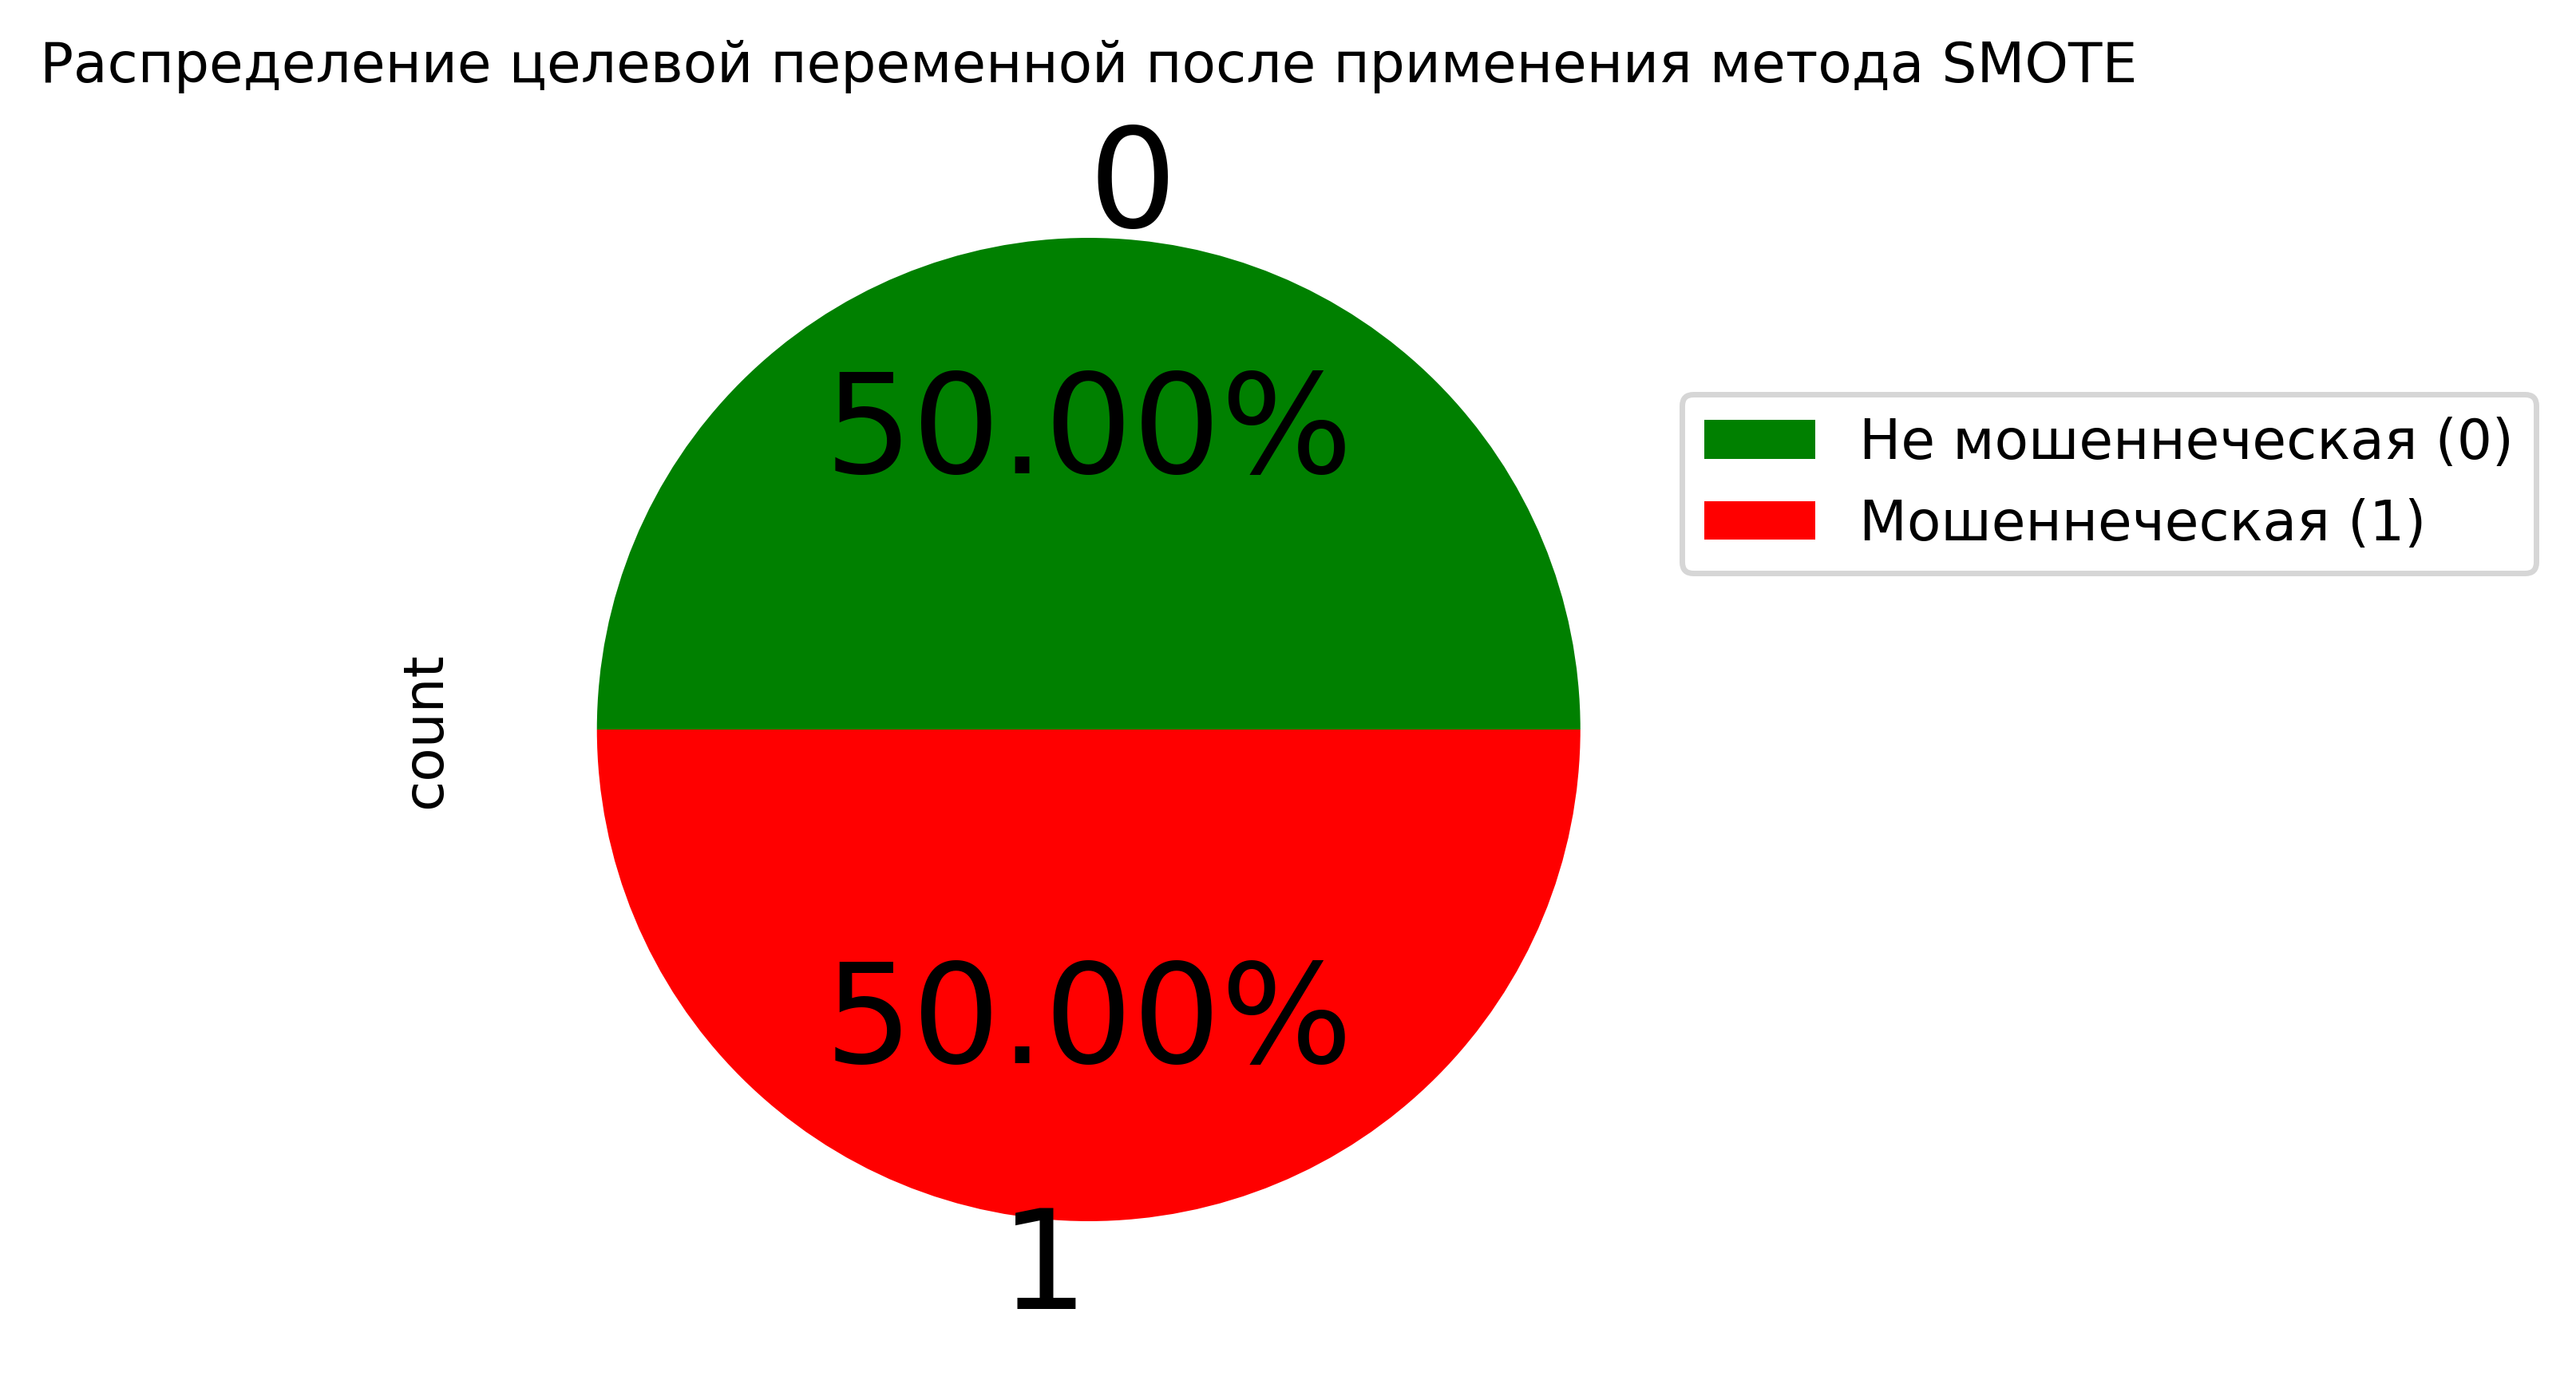

In [64]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_smote).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода SMOTE", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

**Adaptive Synthetic (ADASYN)**

In [36]:
rf_model_adasyn = RandomForestClassifier()
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_adasyn, X_adasyn, y_adasyn, cv=kf, scoring='f1', n_jobs=-1)
start_train = time.perf_counter()
rf_model_adasyn.fit(X_adasyn, y_adasyn)
train_time_adasyn = time.perf_counter() - start_train
prediction_adasyn = rf_model_adasyn.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_adasyn))
print(f'Время обучения модели: {train_time_adasyn} с')

Кросс-валидация F1 scores: [0.95654467 0.86015282 0.86293275 0.89355235 0.89733057], Среднее: 0.894
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 319.08738079993054 с


Среднее значение **F1-score** при кросс-валидации составило 0.894. Модель отличная.

Есть разброс значений **F1-score** от 0.860 до 0.957. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.88 - модель ошибается в 12% случаев, предсказывая положительный класс.

* **Recall** = 0.83 - модель не видит 17% реальных положительных случаев.

* **F1-score** = 0.85

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

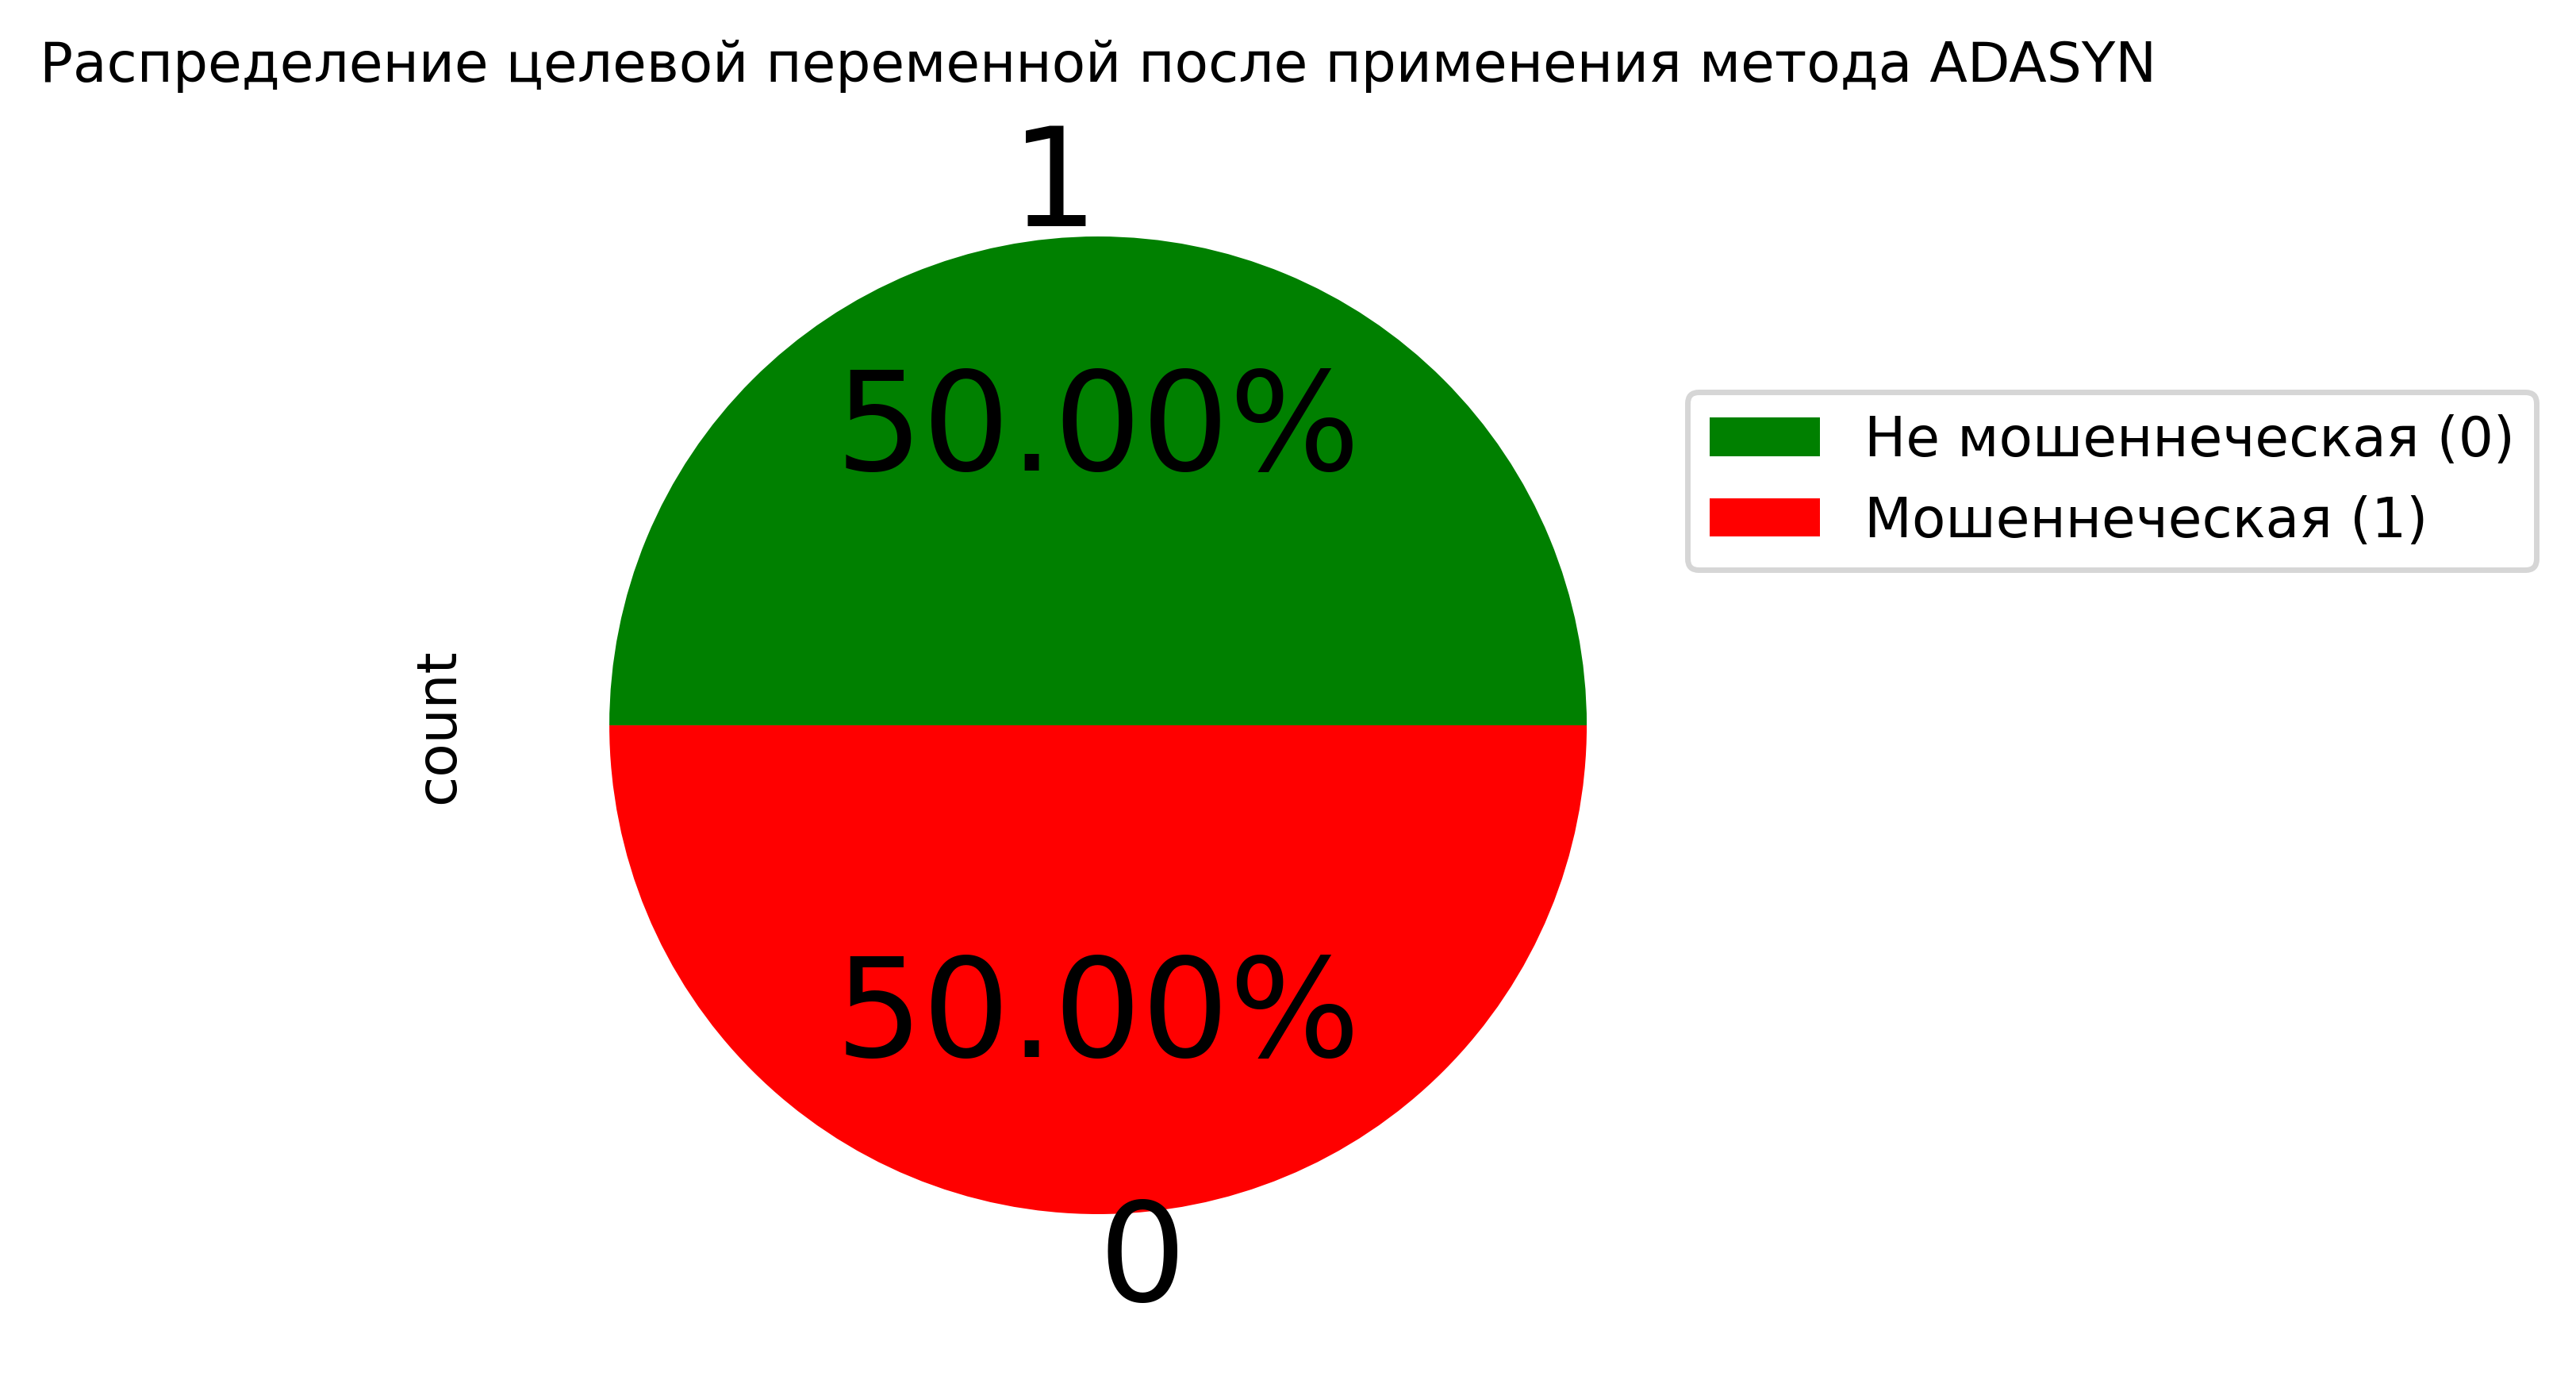

In [66]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_adasyn).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода ADASYN", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

**Random Undersampling**

In [54]:
rf_model_rus = RandomForestClassifier()
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_rus, X_rus, y_rus, cv=kf, scoring='f1', n_jobs=-1)
start_train = time.perf_counter()
rf_model_rus.fit(X_rus, y_rus)
train_time_rus = time.perf_counter() - start_train
prediction_rus = rf_model_rus.predict(X_test)
pred_proba_rus = rf_model_rus.predict_proba(X_test)[:, 1]

print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_rus))
print(f"ROC-AUC: {roc_auc_score(y_test, pred_proba_rus):.3f}")
print(f"Average Precision (AP): {average_precision_score(y_test, pred_proba_rus):.3f}")
print(f'Время обучения модели: {train_time_rus} с')

Кросс-валидация F1 scores: [0.94193548 0.94736842 0.91390728 0.95364238 0.94736842], Среднее: 0.941
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.979
Average Precision (AP): 0.745
Время обучения модели: 0.21414240007288754 с


Среднее значение **F1-score** при кросс-валидации составило 0.941. Модель плохая.

Есть разброс значений **F1-score** от 0.914 до 0.954. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны примерно 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.04 - модель ошибается в 96% случаев, предсказывая положительный класс.

* **Recall** = 0.92 - модель не видит 8% реальных положительных случаев.

* **F1-score** = 0.08

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 0.97, но это неправильно, так как основной вклад вносит класс большинства (0).

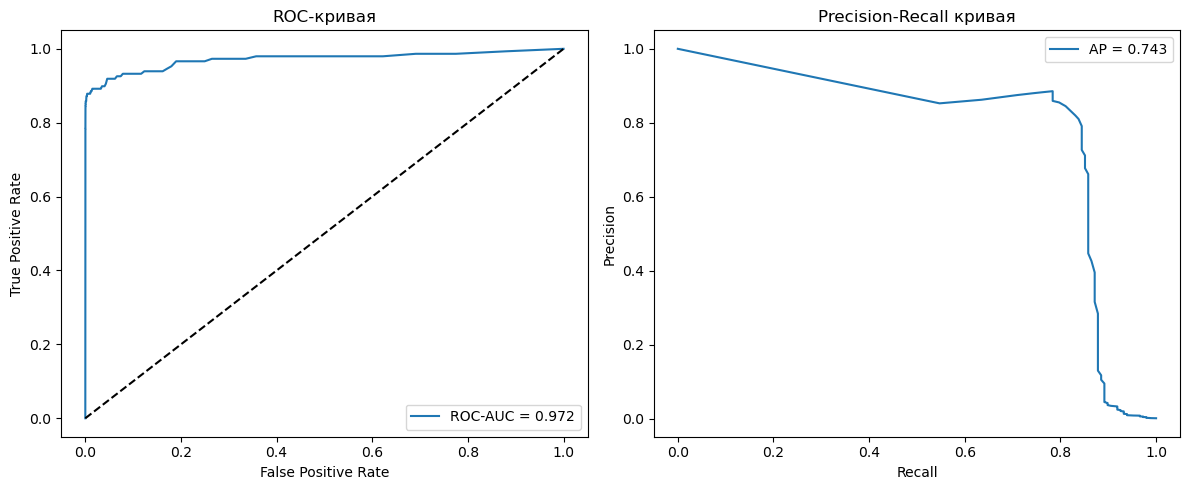

In [91]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, pred_proba)
plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, pred_proba):.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()

plt.tight_layout()
plt.show()

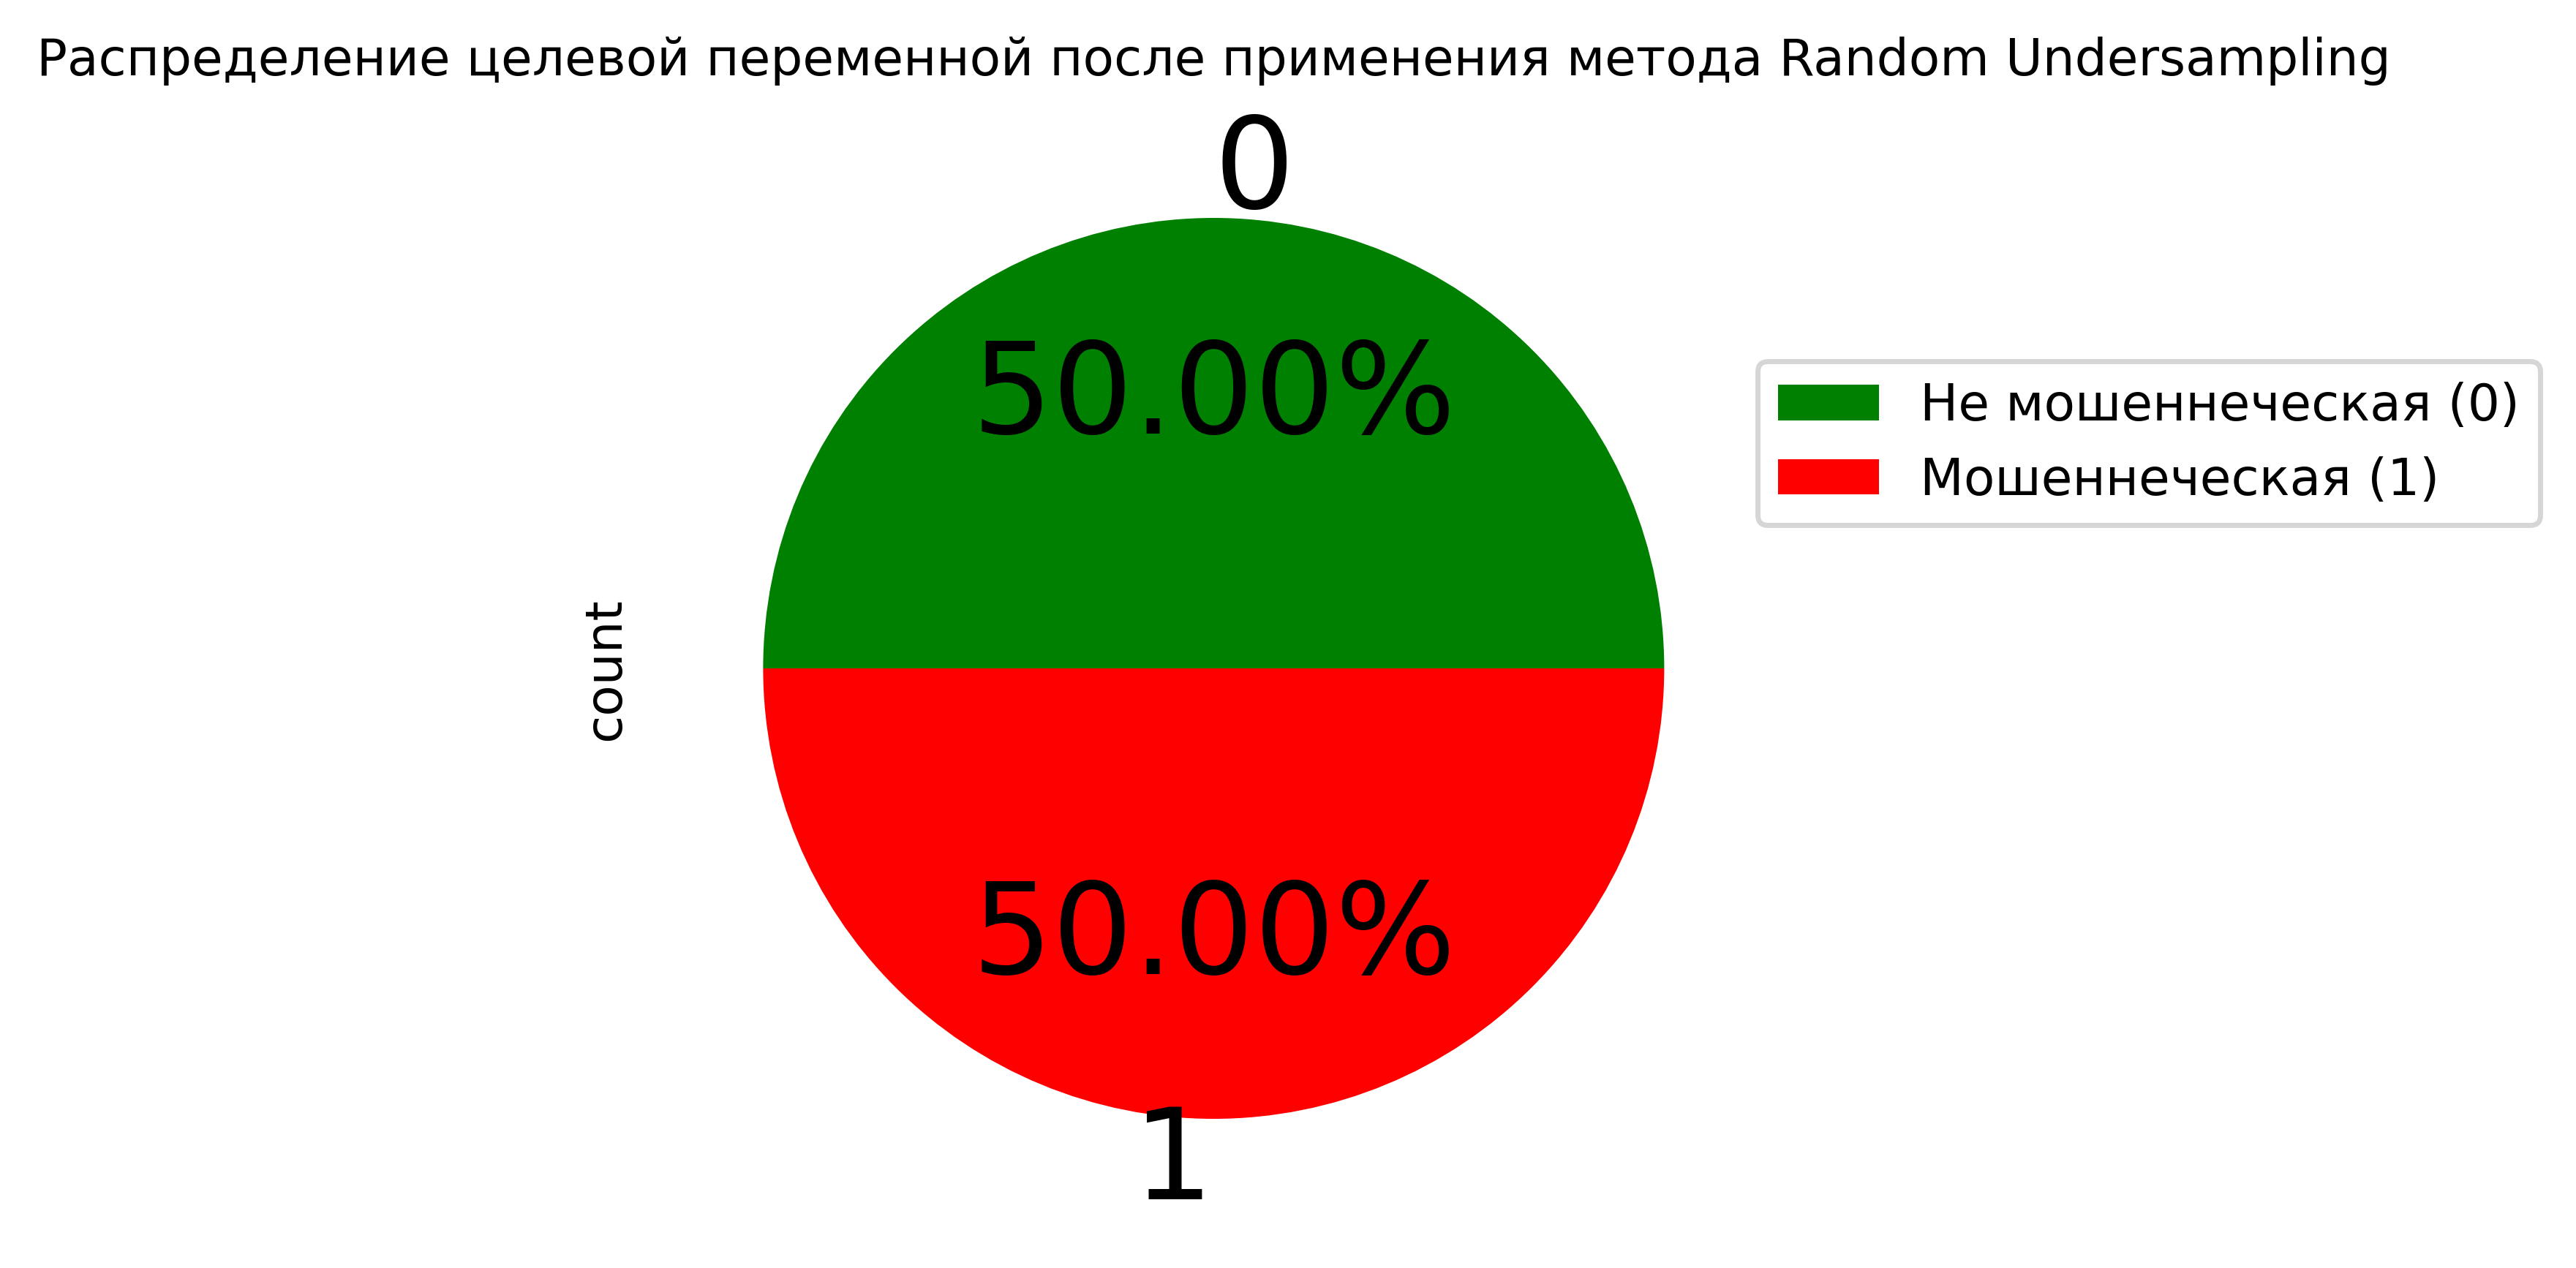

In [68]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_rus).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода Random Undersampling", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

**Tomek Links**

In [58]:
rf_model_tomek = RandomForestClassifier()
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_tomek, X_tomek, y_tomek, cv=kf, scoring='f1', n_jobs=-1)
start_train = time.perf_counter()
rf_model_tomek.fit(X_tomek, y_tomek)
train_time_tomek = time.perf_counter() - start_train
prediction_tomek = rf_model_tomek.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_tomek))
print(f'Время обучения модели: {train_time_tomek} с')

Кросс-валидация F1 scores: [0.79136691 0.91891892 0.84137931 0.86111111 0.83783784], Среднее: 0.850
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.84      0.91        98

    accuracy                           1.00     56962
   macro avg       0.99      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962

Время обучения модели: 163.2840044000186 с


Среднее значение **F1-score** при кросс-валидации составило 0.850. Модель отличная.

Есть разброс значений **F1-score** от 0.791 до 0.919. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.99 - модель ошибается в 1% случаев, предсказывая положительный класс.

* **Recall** = 0.84 - модель не видит 16% реальных положительных случаев.

* **F1-score** = 0.91

Модель хорошо предсказывает большинство (0), но плохо класс меньшинства (1).

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

Отличная модель. **Precision** для класса меньшинства большой, это хорошо. Так как почти все предсказанные положительные случаи верны. К сожалению, модель еще до сих пропускает мошеннические транзакции. Эта модель хороша тем, что она почти с вероятностью 1 предсказывает, что эта транзакция мошенническая. 
Оптимизировать не будем из-за большой вычислительной нагрузки.

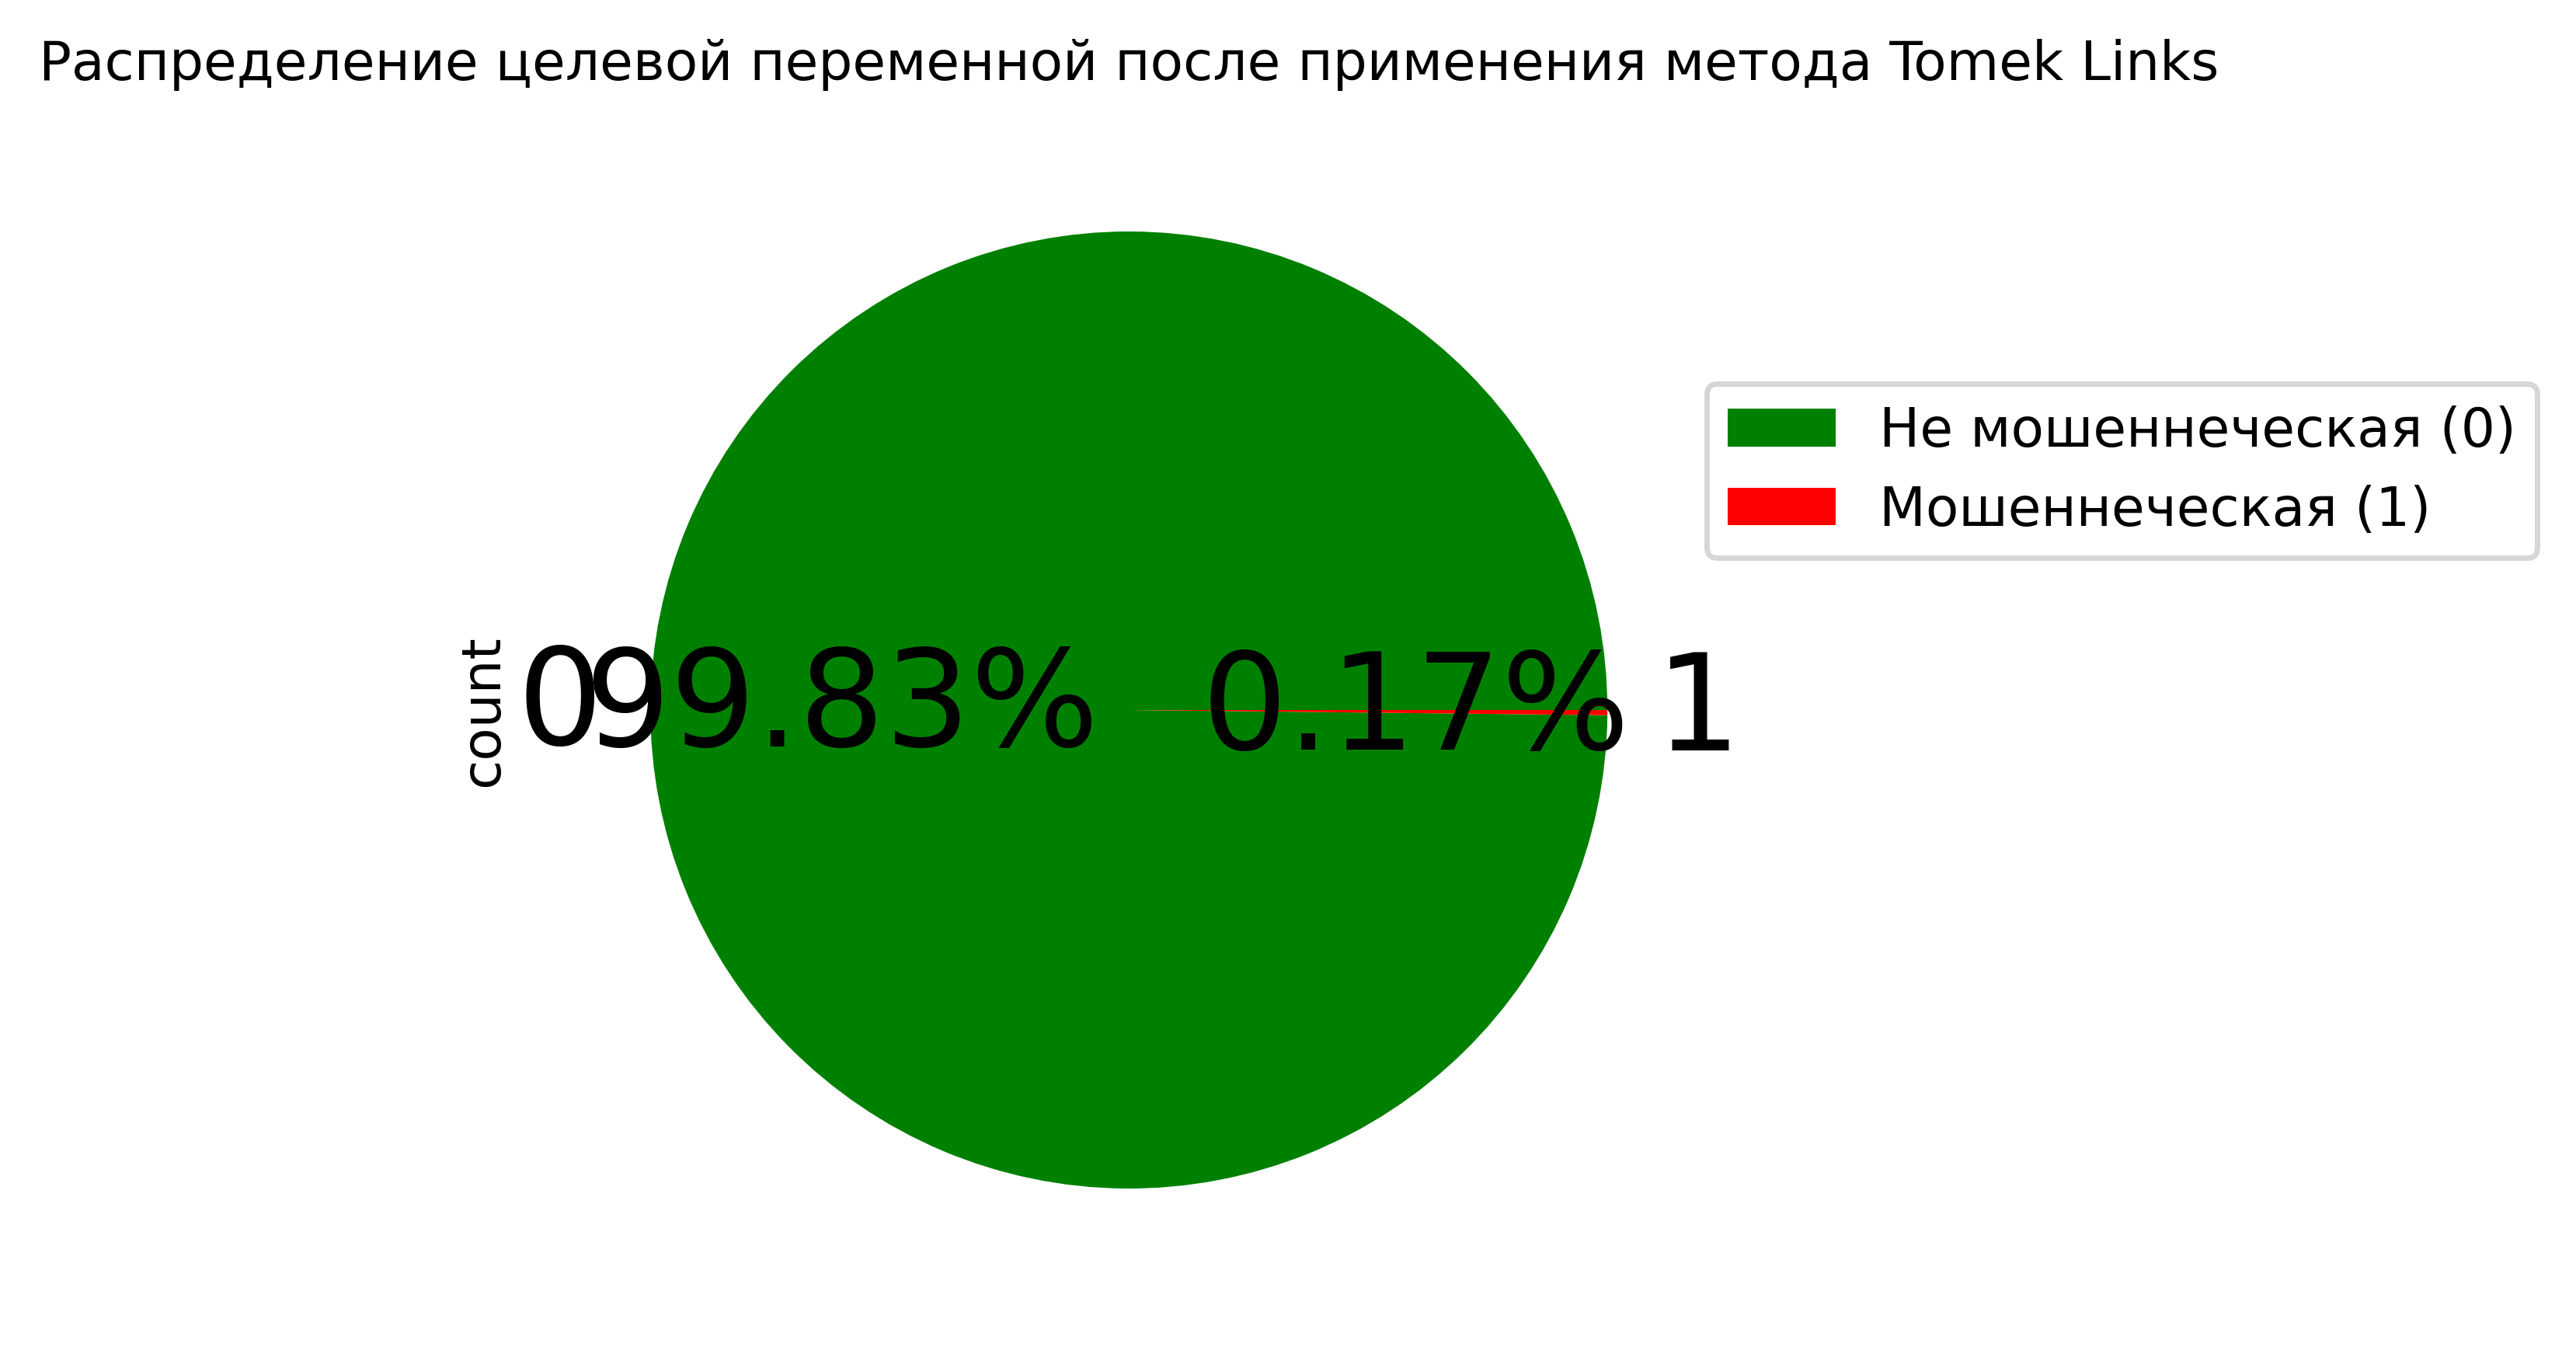

In [70]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_tomek).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода Tomek Links", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

**Cluster Centroids**

In [56]:
rf_model_cc = RandomForestClassifier()
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_cc, X_cc, y_cc, cv=kf, scoring='f1', n_jobs=-1)
start_train = time.perf_counter()
rf_model_cc.fit(X_cc, y_cc)
train_time_cc = time.perf_counter() - start_train
prediction_cc = rf_model_cc.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_cc))
print(f'Время обучения модели: {train_time_cc} с')

Кросс-валидация F1 scores: [0.94117647 0.94805195 0.96052632 0.92903226 0.95541401], Среднее: 0.947
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     56864
           1       0.01      0.93      0.01        98

    accuracy                           0.70     56962
   macro avg       0.50      0.81      0.42     56962
weighted avg       1.00      0.70      0.82     56962

Время обучения модели: 0.2208400999661535 с


Среднее значение **F1-score** при кросс-валидации составило 0.947. Модель плохая.

Есть разброс значений **F1-score** от 0.929 до 0.961. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0):

* **Precision** = 1.00 - модель ошибается в 0% случаев, предсказывая отрицательный класс.

* **Recall** = 0.70 - модель не видит 30% реальных отрицательных случаев.

* **F1-score** = 0.82

Для класса меньшинства (1):

* **Precision** = 0.01 - модель ошибается в 99% случаев, предсказывая положительный класс..

* **Recall** = 0.93 - модель не видит 7% реальных положительных случаев.

* **F1-score** = 0.01

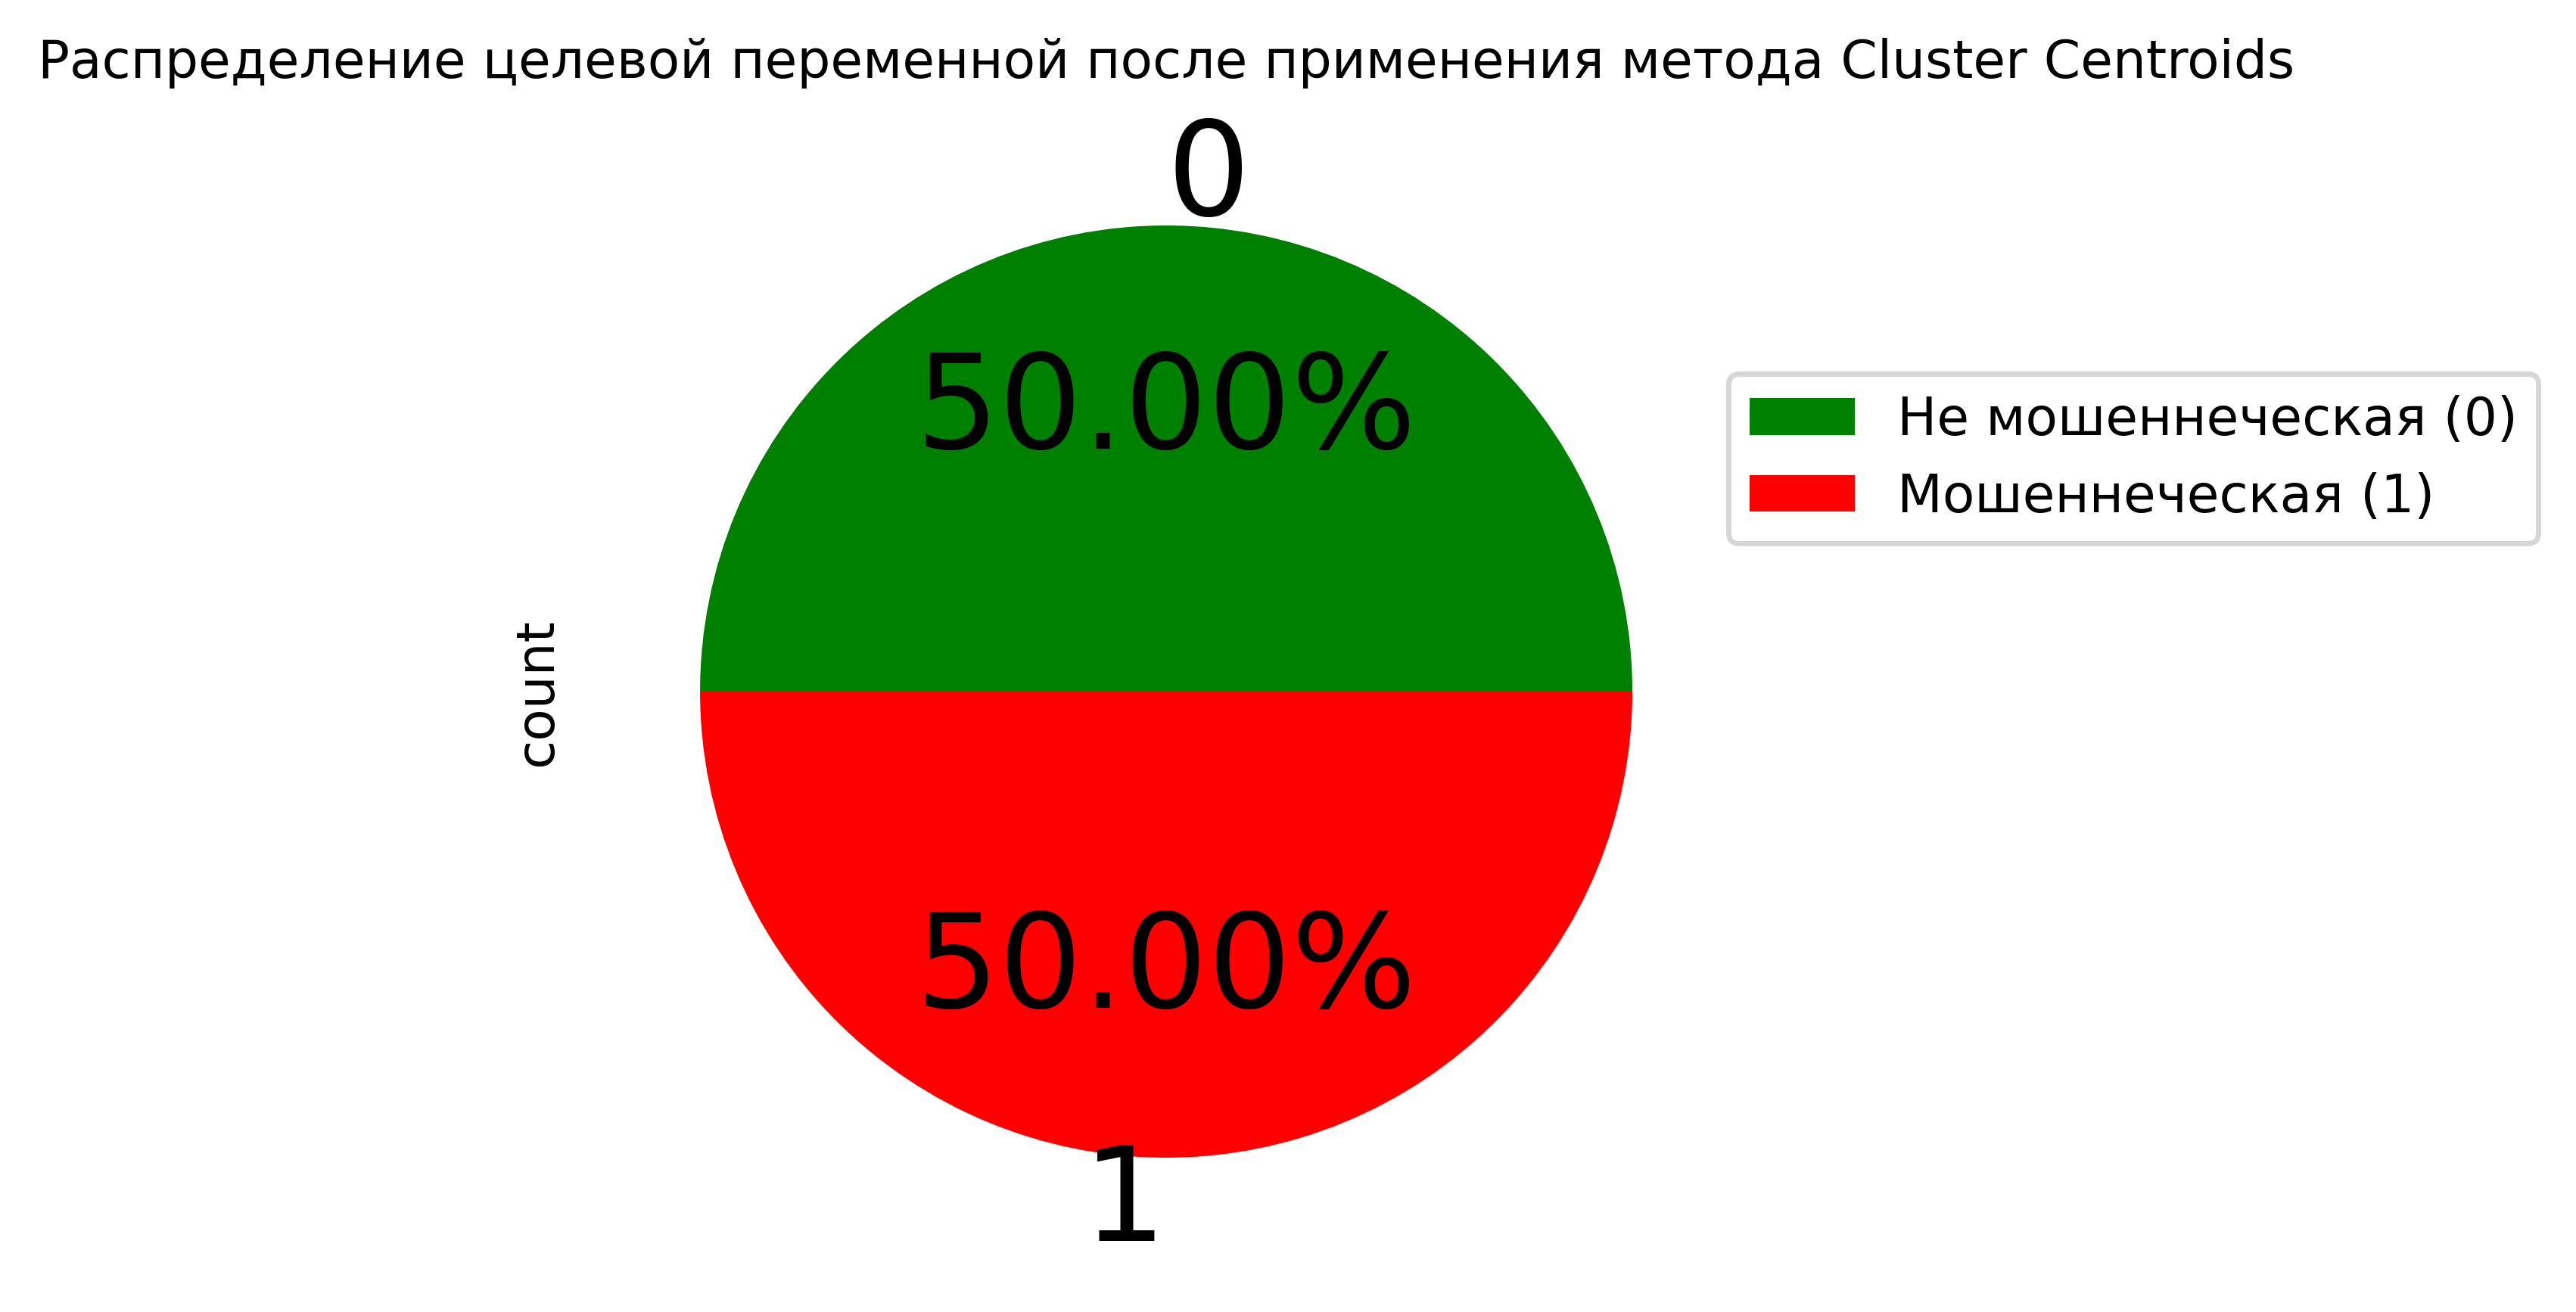

In [72]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_cc).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода Cluster Centroids", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

**NEARMISS**

In [57]:
rf_model_nearmiss = RandomForestClassifier()
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X_train, y_train)
scores = cross_val_score(rf_model_nearmiss, X_nearmiss, y_nearmiss, cv=kf, scoring='f1', n_jobs=-1)
start_train = time.perf_counter()
rf_model_nearmiss.fit(X_nearmiss, y_nearmiss)
train_time_nearmiss = time.perf_counter() - start_train
prediction_nearmiss = rf_model_nearmiss.predict(X_test)
print(f"Кросс-валидация F1 scores: {scores}, Среднее: {scores.mean():.3f}")
print(classification_report(y_test, prediction_nearmiss))
print(f'Время обучения модели: {train_time_nearmiss} с')

Кросс-валидация F1 scores: [0.96103896 0.99363057 0.97402597 0.96732026 0.97435897], Среднее: 0.974
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     56864
           1       0.00      0.97      0.00        98

    accuracy                           0.06     56962
   macro avg       0.50      0.51      0.06     56962
weighted avg       1.00      0.06      0.11     56962

Время обучения модели: 0.20984909986145794 с


Среднее значение **F1-score** при кросс-валидации составило 0.974. Модель плохая.

Есть разброс значений **F1-score** от 0.961 до 0.994. Модель нестабильна на разных подвыборках данных.

Для класса большинства (0):

* **Precision** = 1.00 - модель ошибается в 0% случаев, предсказывая отрицательный класс.

* **Recall** = 0.06 - модель не видит 94% реальных отрицательных случаев.

* **F1-score** = 0.11

Для класса меньшинства (1):

* **Precision** = 0.00 - модель ошибается в 100% случаев, предсказывая положительный класс.

* **Recall** = 0.97 - модель не видит 3% реальных положительных случаев.

* **F1-score** = 0.00

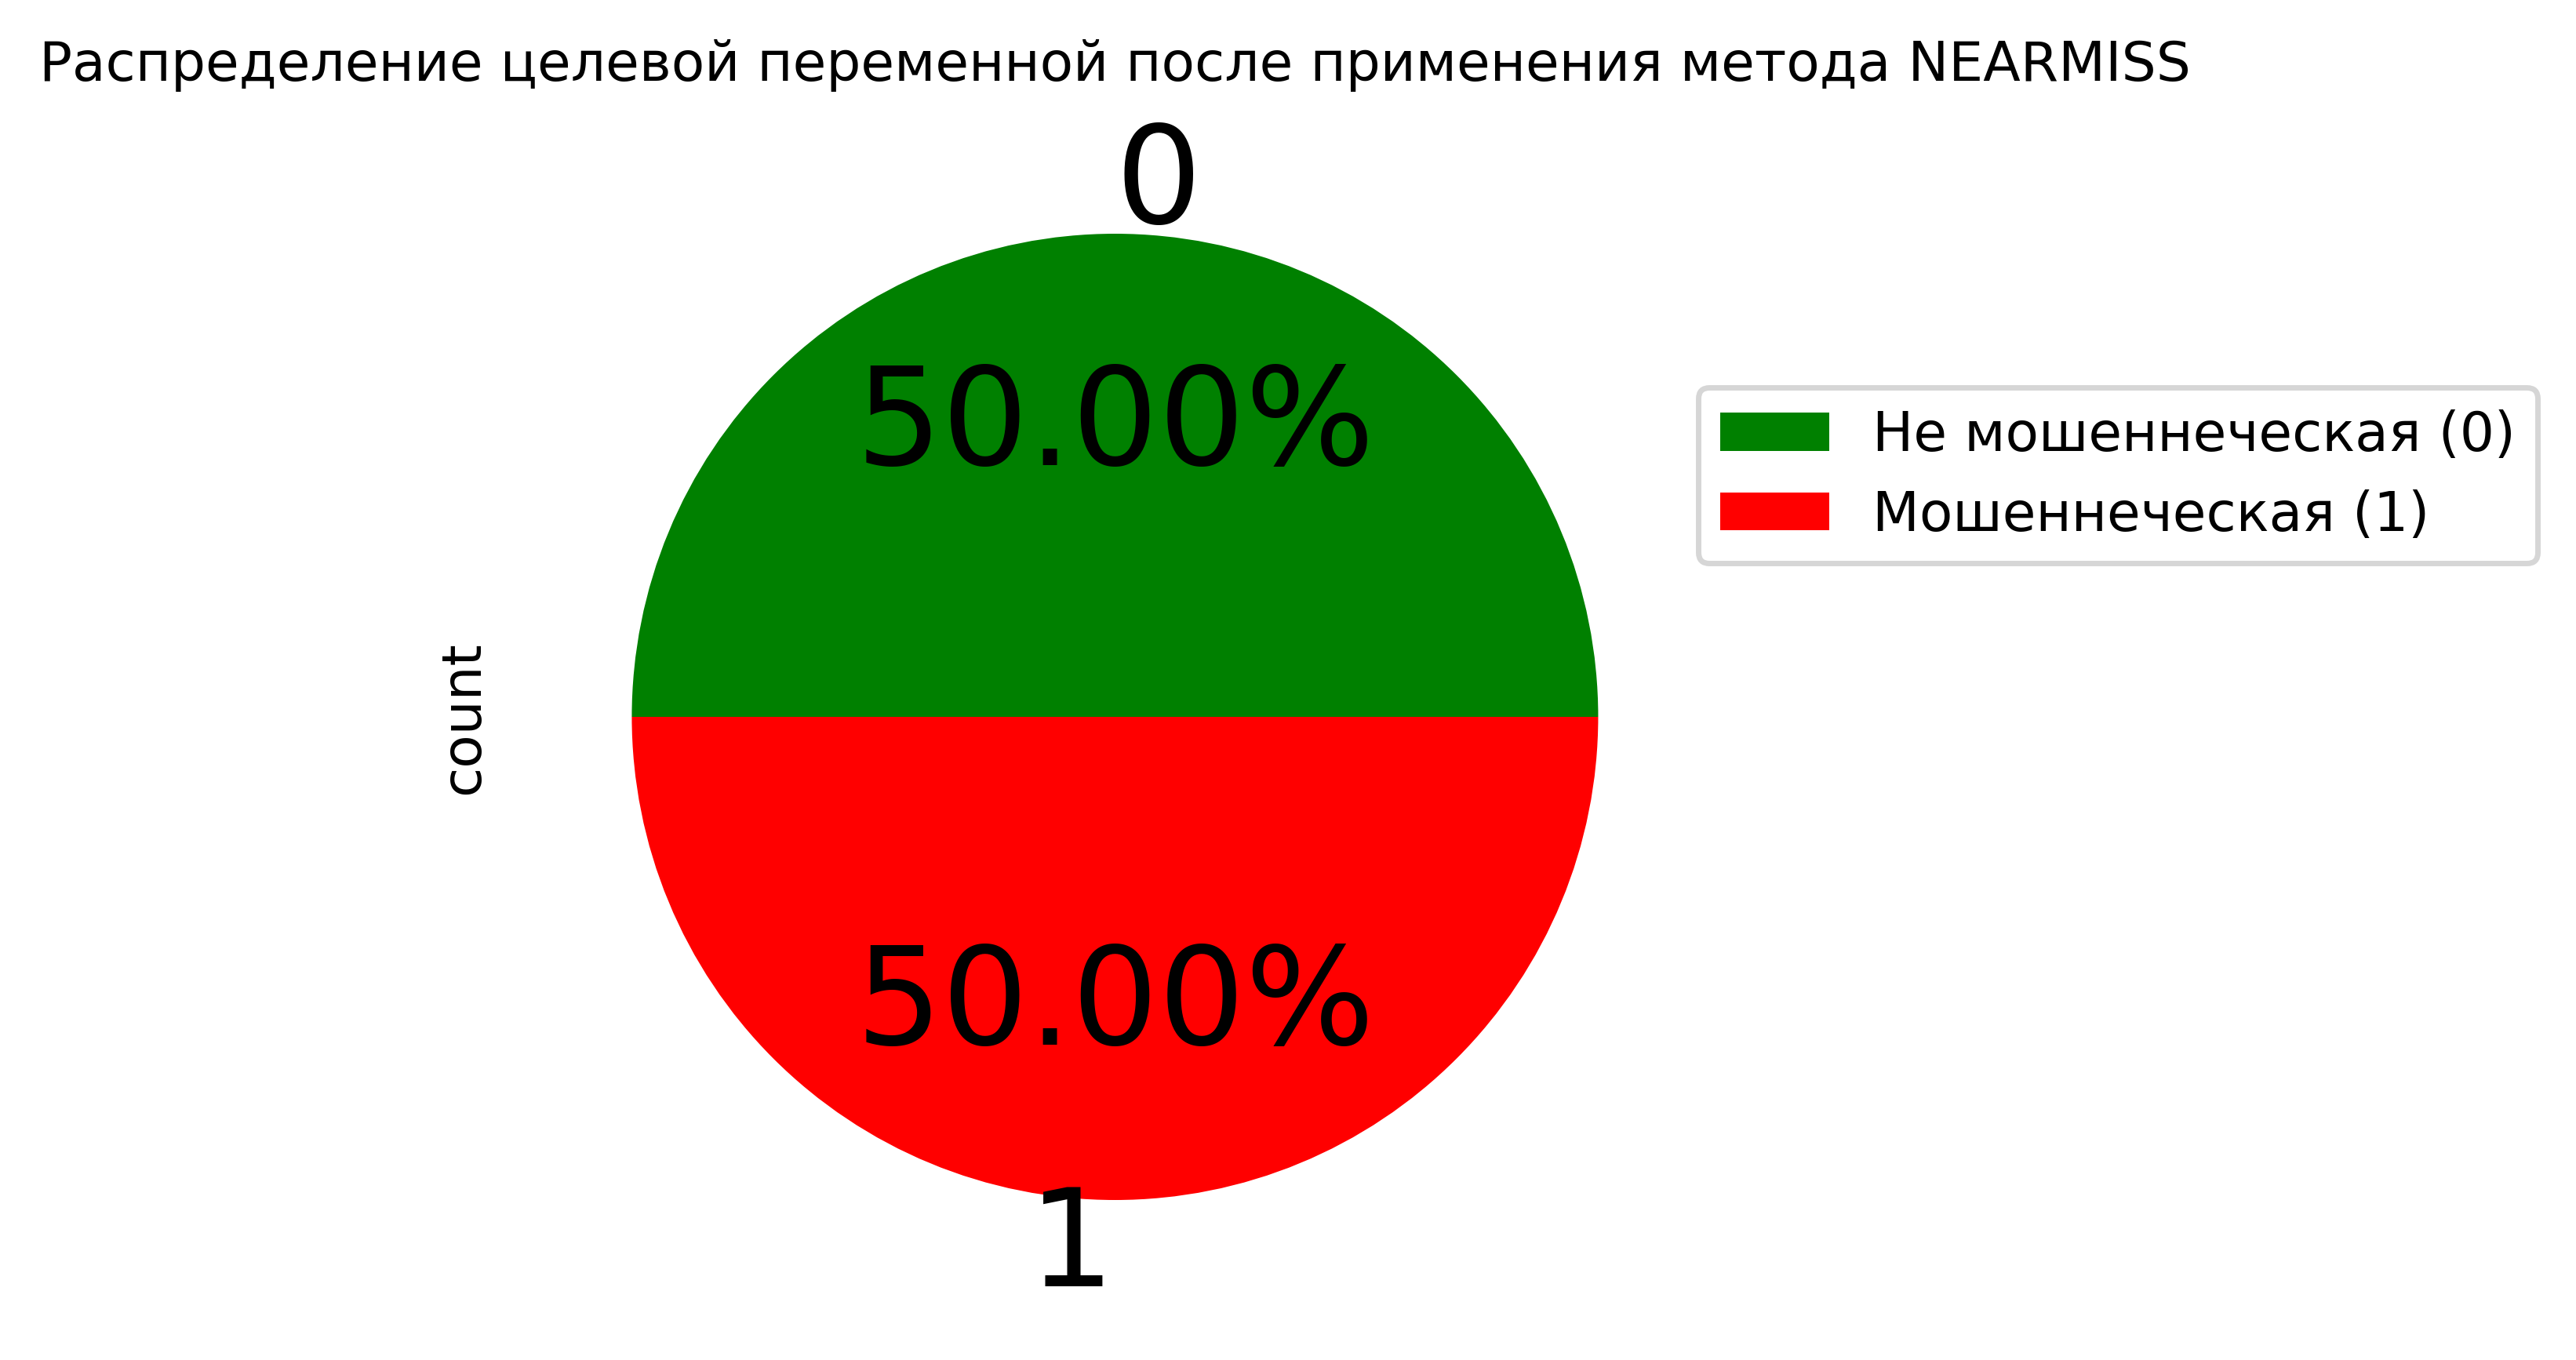

In [74]:
plt.figure(figsize=(4,4), dpi = 500)
pd.Series(y_nearmiss).value_counts().plot(kind = 'pie', autopct='%1.2f%%', fontsize = 25, colors=['g','r'])
plt.title("Распределение целевой переменной после применения метода NEARMISS", fontsize = 10)
plt.legend(["Не мошеннеческая (0)", "Мошеннеческая (1)"], loc ='right', bbox_to_anchor=(1.7, 0.7))
plt.show()

In [78]:
model_predictions = {
    "Random Forest": prediction_rf,
    "SMOTE": prediction_smote,
    "ADASYN": prediction_adasyn,
    "Random Undersampling": prediction_rus,
    "Tomek Links": prediction_tomek,
    "Cluster Centroids": prediction_cc,
    "NEARMISS": prediction_nearmiss
}

train_times = {
    "Random Forest": train_time_rf,
    "SMOTE": train_time_smote,
    "ADASYN": train_time_adasyn,
    "Random Undersampling": train_time_rus,
    "Tomek Links": train_time_tomek,
    "Cluster Centroids": train_time_cc,
    "NEARMISS": train_time_nearmiss
}

results = []

for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    metrics = {
        "Модель": model_name,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
        "Время обучения (с)": train_times[model_name]
    }
    
    results.append(metrics)

data_results_2 = pd.DataFrame(results)
data_results_2

,Модель,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,Время обучения (с)
0,Random Forest,0.999701,0.999982,0.999842,0.987805,0.826531,0.900000,0.999684,163.212322
1,SMOTE,0.999701,0.999824,0.999763,0.890110,0.826531,0.857143,0.999526,284.869068
2,ADASYN,0.999701,0.999842,0.999771,0.900000,0.826531,0.861702,0.999544,471.946669
3,Random Undersampling,0.999854,0.965321,0.982284,0.043647,0.918367,0.083333,0.965240,0.214142
4,Tomek Links,0.999701,0.999982,0.999842,0.987805,0.826531,0.900000,0.999684,161.750567
5,Cluster Centroids,0.999823,0.695818,0.820569,0.005233,0.928571,0.010408,0.696219,0.220840
6,NEARMISS,0.999069,0.056609,0.107146,0.001768,0.969388,0.003529,0.058179,0.209849


**Выводы по работе моделей**

1. Лучшие модели для класса меньшинства (1): **SMOTE**, **ADASYN**,**Tomek Links**
3. Худшие модели: **Cluster Centroids**, **Random Undersampling**, **NEARMISS**
4. Самые быстрые модели: **NEARMISS**,  **Cluster Centroids**, **Random Undersampling**, но они некачественные
5. Самые медленные модели: **SMOTE**, **ADASYN**, **Tomek Links**

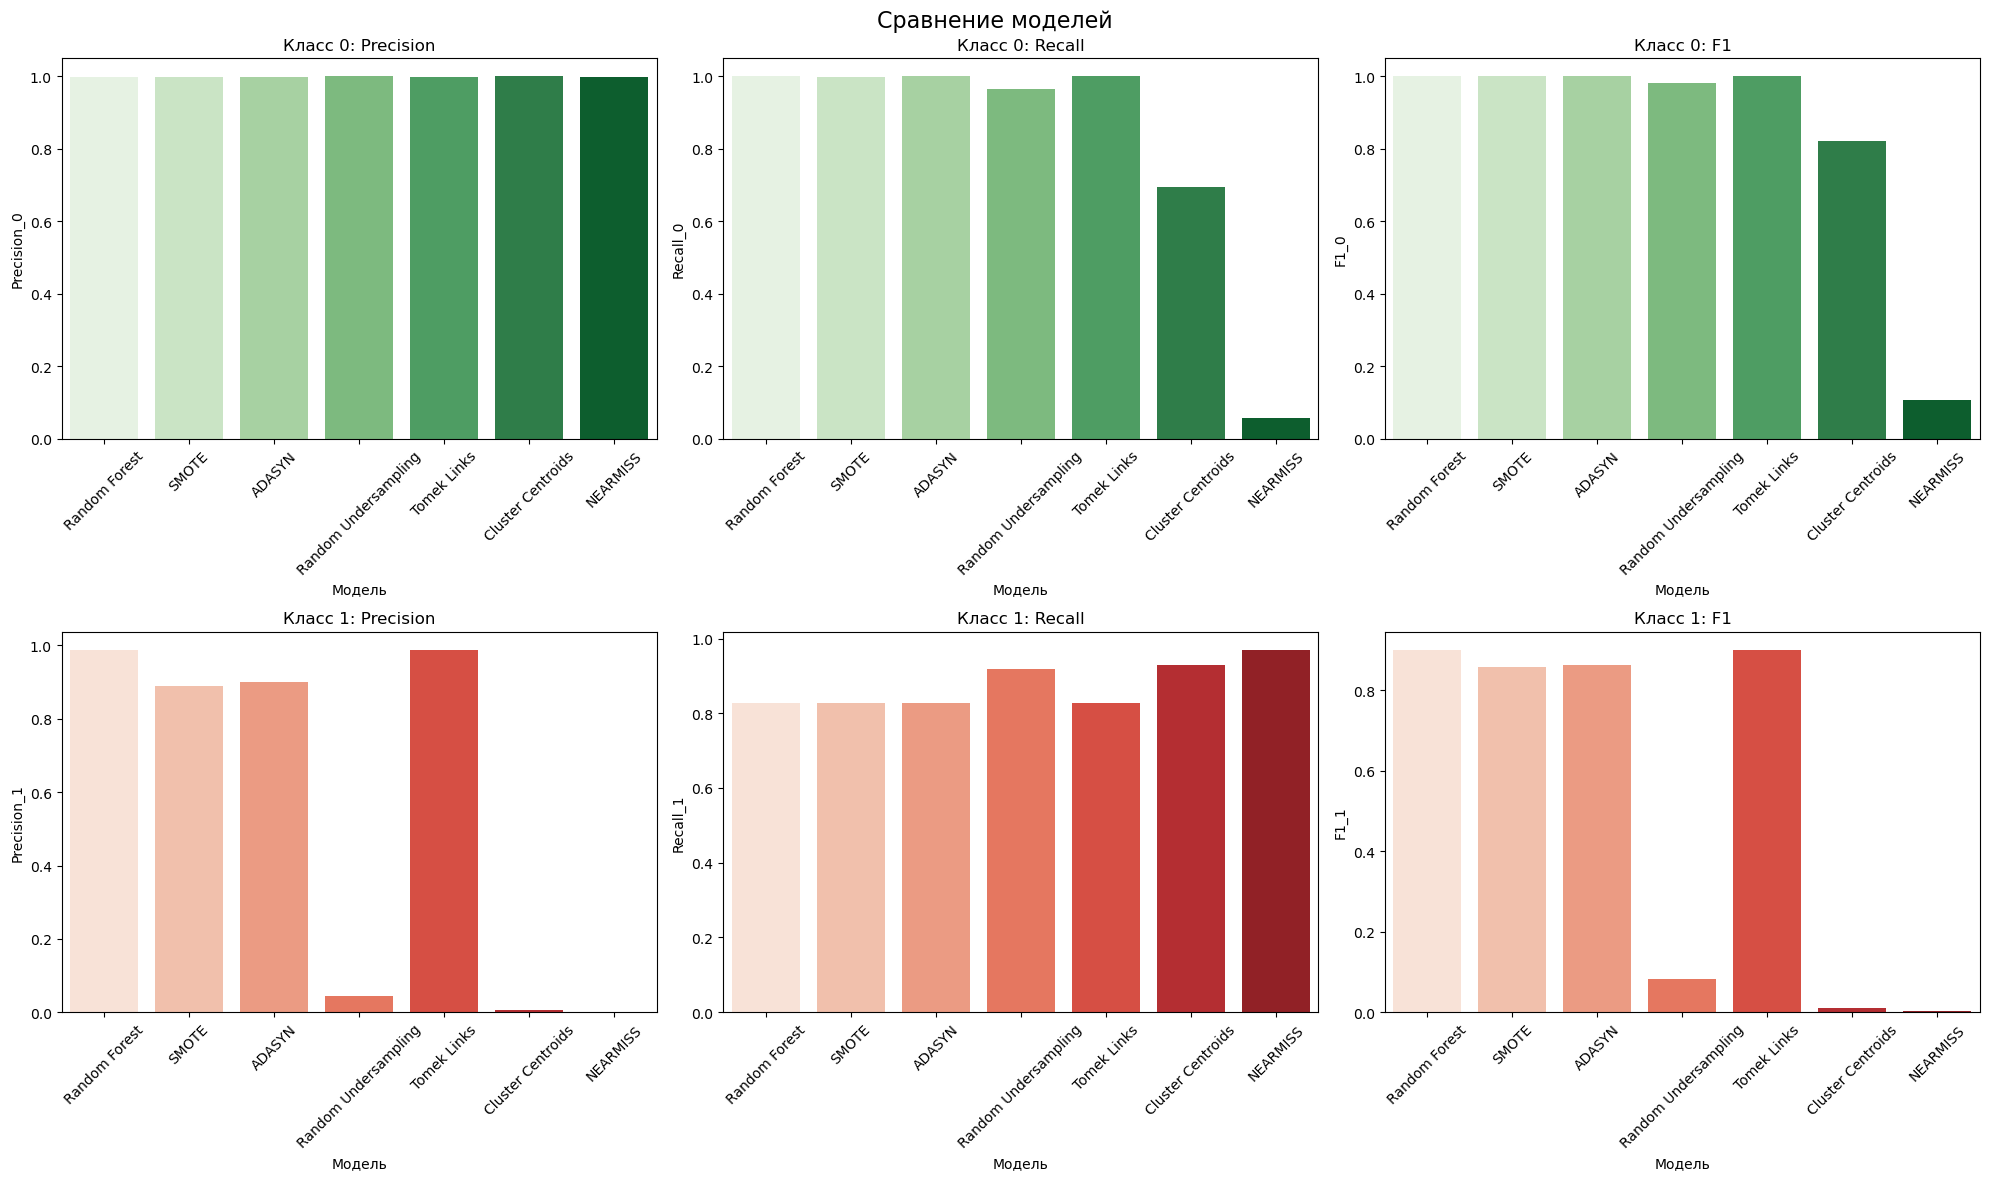

In [233]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Сравнение моделей', fontsize=16)

for i, metric in enumerate(['Precision_0', 'Recall_0', 'F1_0']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_2,
        ax=axes[0, i],
        palette='Greens'
    )
    axes[0, i].set_title(f'Класс 0: {metric.split("_")[0]}')
    axes[0, i].tick_params(axis='x', rotation=45)

for i, metric in enumerate(['Precision_1', 'Recall_1', 'F1_1']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_2,
        ax=axes[1, i],
        palette='Reds'
    )
    axes[1, i].set_title(f'Класс 1: {metric.split("_")[0]}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()

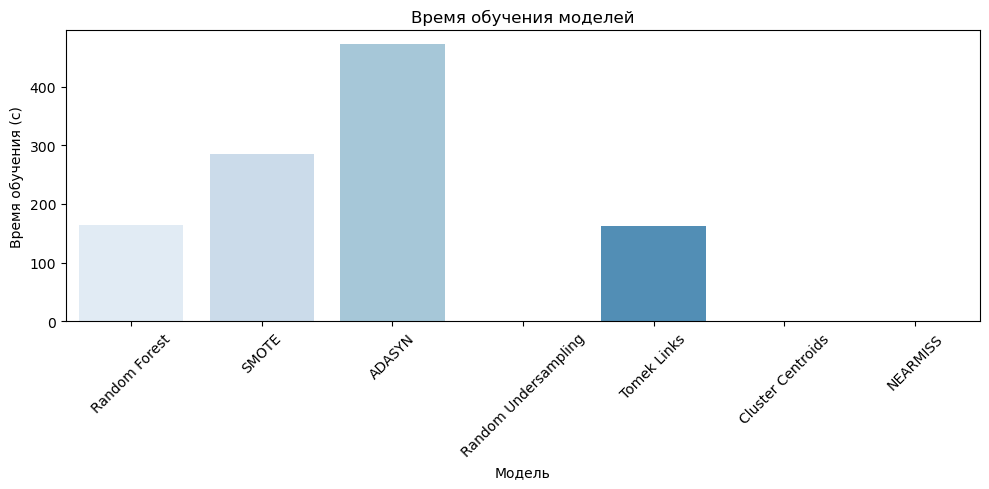

In [237]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Модель', 
    y='Время обучения (с)', 
    data=data_results_2,
    palette='Blues'
)
plt.title('Время обучения моделей')
plt.xticks(rotation=45)
plt.tight_layout()

## Оптимизация моделей 

Для оптимизации были выбраны методы в комбинации с Random Forest: **SMOTE**, **ADASYN**, **Tomek Links**, как самые жизнеспособные модели.

**SMOTE + Random Forest**

In [90]:
def objective(trial):
    params = {
        'smote__k_neighbors': trial.suggest_int('smote__k_neighbors', 3, 10),
        'smote__sampling_strategy': trial.suggest_float('smote__sampling_strategy', 0.5, 1.0),
        
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 300),
        'model__max_depth': trial.suggest_int('model__max_depth', 5, 30),
        'model__class_weight': trial.suggest_categorical('model__class_weight', ['balanced', None])
    }
    
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
    ]).set_params(**params)
    
    return cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1',n_jobs=-1).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=7)

smote_rf = Pipeline([
    ('smote', SMOTE()),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
]).set_params(**study.best_params)

[I 2025-04-28 18:21:28,378] A new study created in memory with name: no-name-a37103a3-af4c-40ec-904d-c42dfff55390
[I 2025-04-28 18:31:27,509] Trial 0 finished with value: 0.7750635056952563 and parameters: {'smote__k_neighbors': 4, 'smote__sampling_strategy': 0.8302074080439161, 'model__n_estimators': 247, 'model__max_depth': 14, 'model__class_weight': 'balanced'}. Best is trial 0 with value: 0.7750635056952563.
[I 2025-04-28 18:34:38,998] Trial 1 finished with value: 0.4607272999915473 and parameters: {'smote__k_neighbors': 10, 'smote__sampling_strategy': 0.653792520739988, 'model__n_estimators': 145, 'model__max_depth': 7, 'model__class_weight': 'balanced'}. Best is trial 0 with value: 0.7750635056952563.
[I 2025-04-28 18:48:06,277] Trial 2 finished with value: 0.8339174189972549 and parameters: {'smote__k_neighbors': 9, 'smote__sampling_strategy': 0.7598629319321619, 'model__n_estimators': 291, 'model__max_depth': 30, 'model__class_weight': 'balanced'}. Best is trial 2 with value: 0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [100]:
start_train = time.perf_counter()
smote_rf.fit(X_train, y_train)
train_time_smote_rf = time.perf_counter() - start_train

prediction_smote_rf = smote_rf.predict(X_test)
y_proba = smote_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, prediction_smote_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.91 - модель ошибается в 9% случаев, предсказывая положительный класс.

* **Recall** = 0.84 - модель не видит 16% реальных положительных случаев.

* **F1-score** = 0.87

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

In [92]:
print(f"Лучшие параметры: {study.best_params}")

Лучшие параметры: {'smote__k_neighbors': 4, 'smote__sampling_strategy': 0.6638525131084925, 'model__n_estimators': 150, 'model__max_depth': 24, 'model__class_weight': None}


In [58]:
params = {
    'smote__k_neighbors': 4,
    'smote__sampling_strategy': 0.664,
    'randomforestclassifier__n_estimators': 150,
    'randomforestclassifier__max_depth': 24
}

model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
]).set_params(**params)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='f1', n_jobs=-1)

print(f"Кросс-валидация F1 scores: {scores.round(4)}, Среднее: {scores.mean():.4f}")
print(f"Разброс: {scores.max()-scores.min():.4f}")

Кросс-валидация F1 scores: [0.8541 0.9016 0.8757 0.8432 0.8542], Среднее: 0.8657
Разброс: 0.0583


Модель при лучших параметрах **устойчива**.

In [103]:
model_predictions = {
    "Random Forest": prediction_rf,
    "SMOTE": prediction_smote,
    "SMOTE + RF": prediction_smote_rf
}

train_times = {
    "Random Forest": train_time_rf,
    "SMOTE": train_time_smote,
    "SMOTE + RF": train_time_smote_rf
}

results = []

for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    metrics = {
        "Модель": model_name,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
        "Время обучения (с)": train_times[model_name]
    }
    
    results.append(metrics)

data_results_smote_rf = pd.DataFrame(results)
data_results_smote_rf

,Модель,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,Время обучения (с)
0,Random Forest,0.999701,0.999982,0.999842,0.987805,0.826531,0.900000,0.999684,163.212322
1,SMOTE,0.999701,0.999824,0.999763,0.890110,0.826531,0.857143,0.999526,284.869068
2,SMOTE + RF,0.999719,0.999859,0.999789,0.911111,0.836735,0.872340,0.999579,86.084140


**Выводы по работе моделей**

1. Оптимизация прошла успешно за счёт снижения времени обучения почти в **2 раза** по сравнению с **Random Forest** и в **боллее 3 раза** по сравнинию с **Smote** методом
2. Оптимизированная модель устойчива
3. Удалось добиться более высоких метрик по сравнеию с **SMOTE**

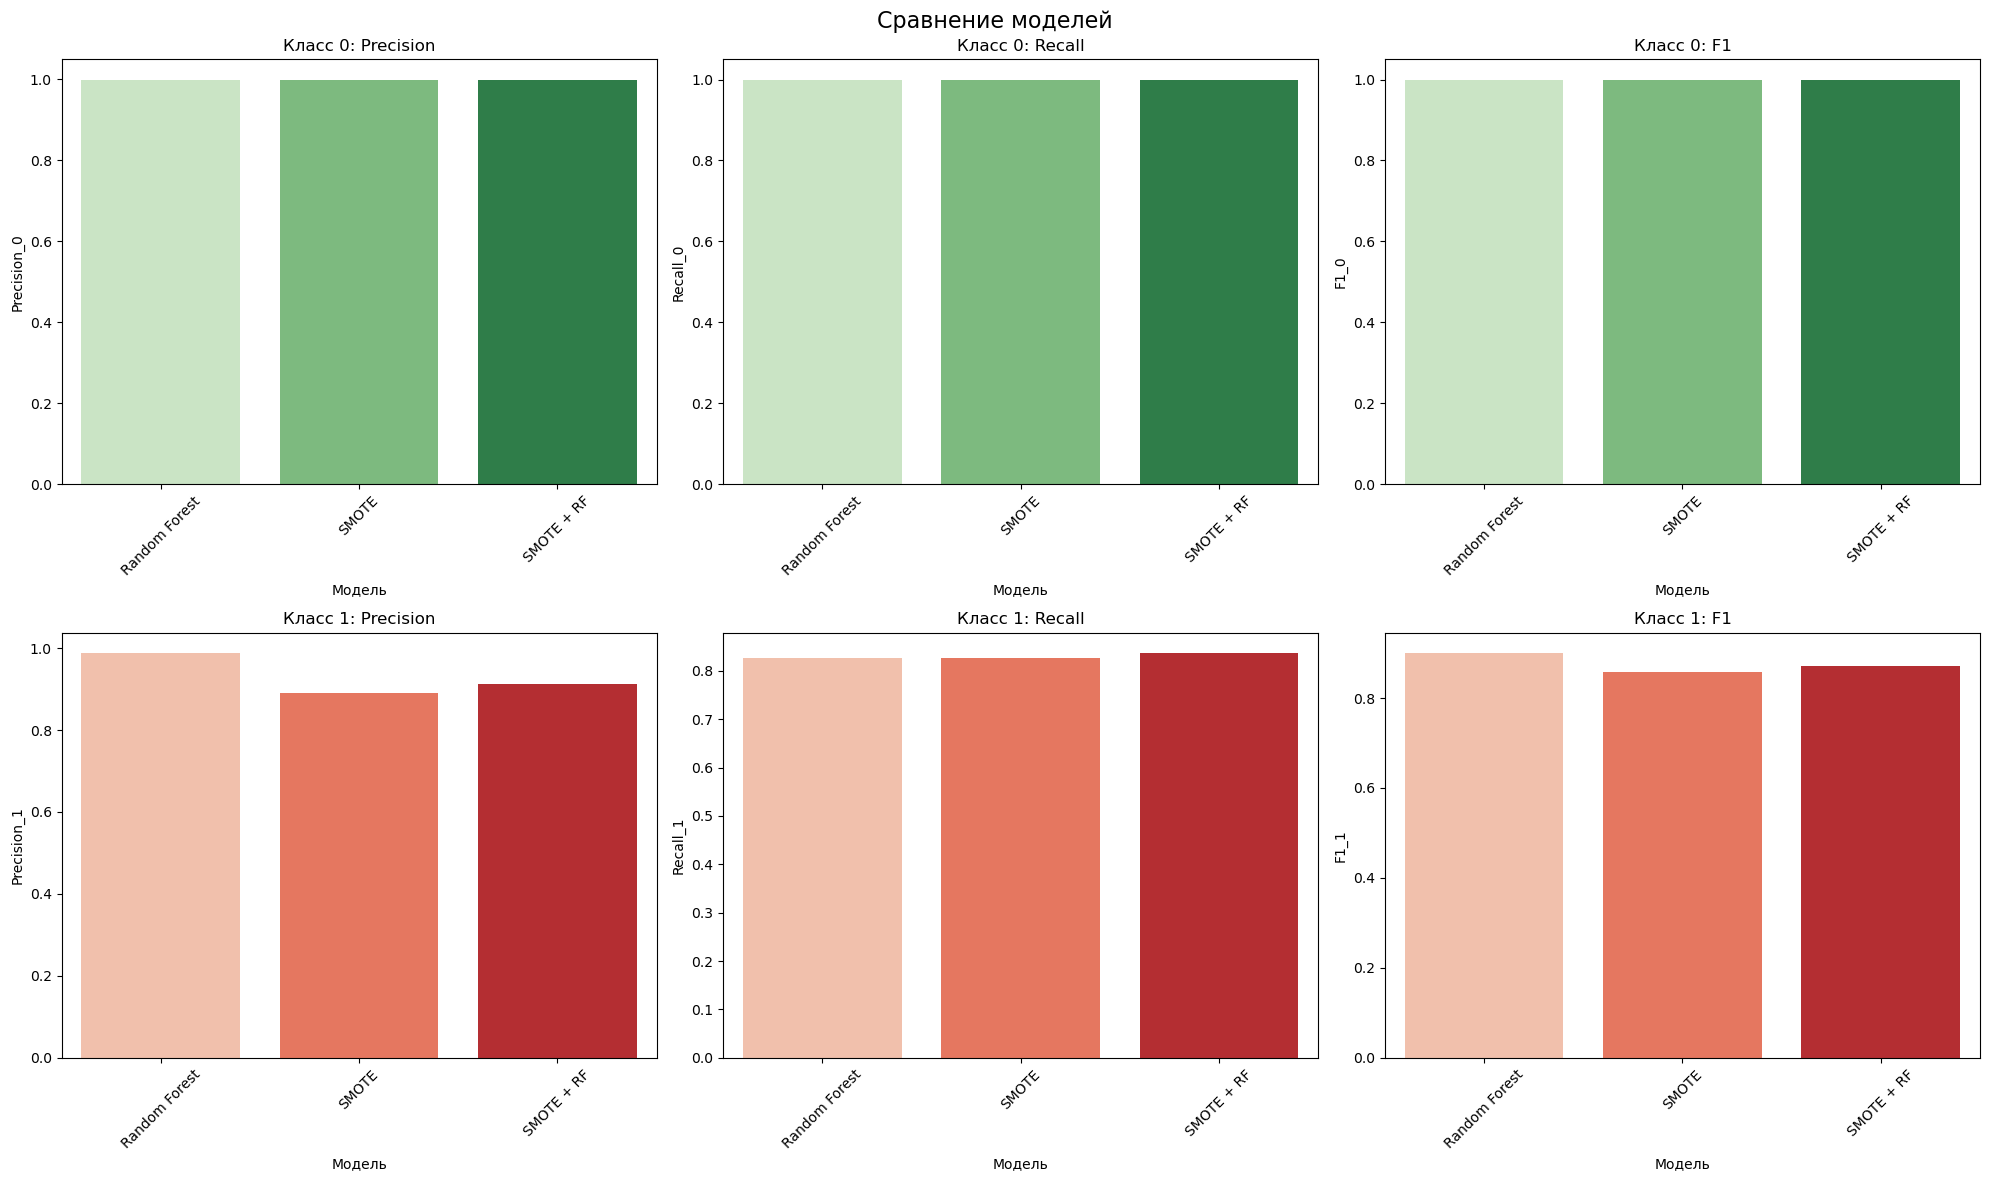

In [179]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Сравнение моделей', fontsize=16)

for i, metric in enumerate(['Precision_0', 'Recall_0', 'F1_0']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_smote_rf,
        ax=axes[0, i],
        palette='Greens'
    )
    axes[0, i].set_title(f'Класс 0: {metric.split("_")[0]}')
    axes[0, i].tick_params(axis='x', rotation=45)

for i, metric in enumerate(['Precision_1', 'Recall_1', 'F1_1']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_smote_rf,
        ax=axes[1, i],
        palette='Reds'
    )
    axes[1, i].set_title(f'Класс 1: {metric.split("_")[0]}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()

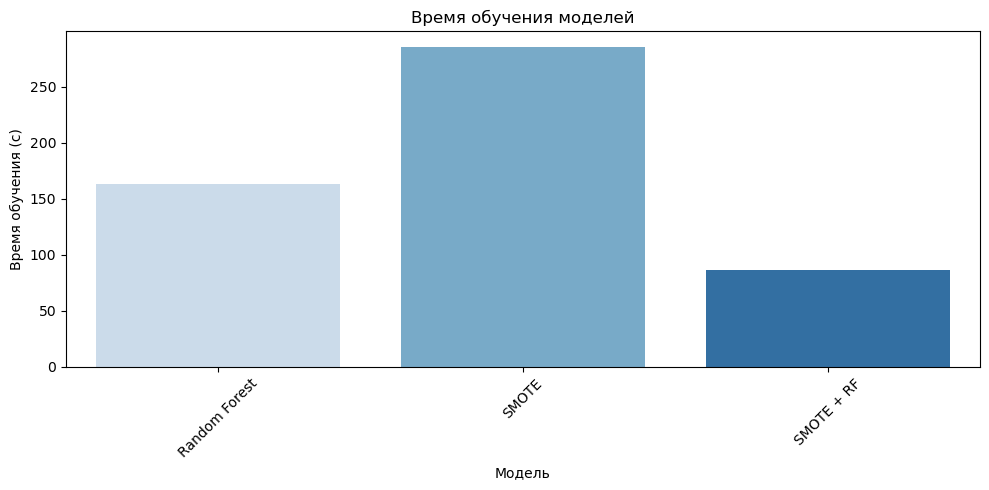

In [167]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Модель', 
    y='Время обучения (с)', 
    data=data_results_smote_rf,
    palette='Blues'
)
plt.title('Время обучения моделей')
plt.xticks(rotation=45)
plt.tight_layout()

**SMOTE + RF** быстрее всех

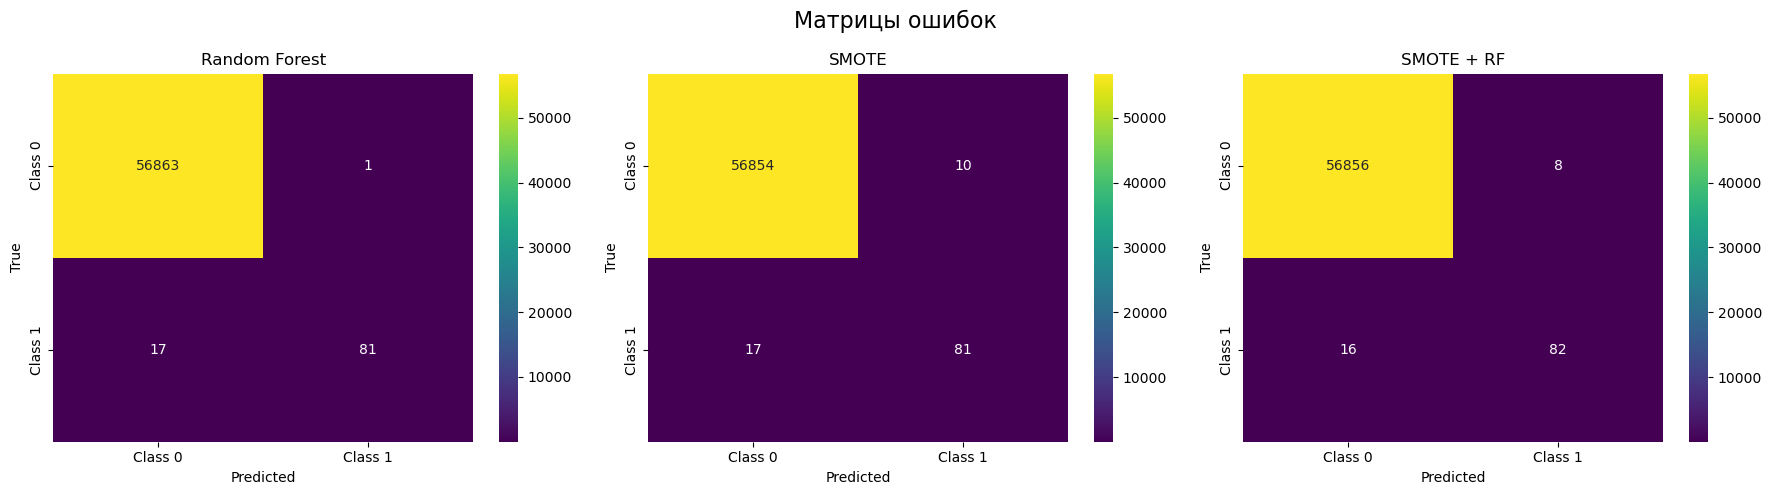

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Матрицы ошибок', fontsize=16)

for ax, (model_name, y_pred) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='viridis',
        ax=ax,
        xticklabels=['Class 0', 'Class 1'],
        yticklabels=['Class 0', 'Class 1']
    )
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

Через оптимизацию удалось **снизить** количество неверно предсказанных объектов для класса меньшинства (1).

In [189]:
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_smote = rf_model_smote.predict_proba(X_test)[:, 1]
y_proba_smote_rf = smote_rf.predict_proba(X_test)[:, 1]

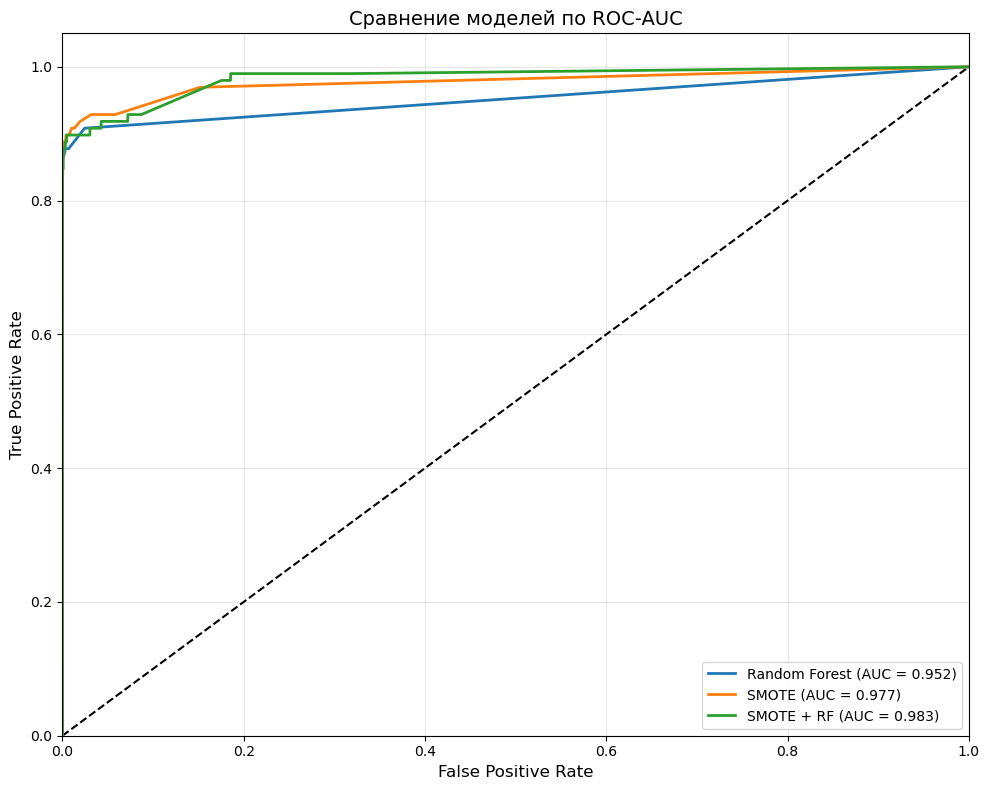

In [213]:
model_probabilities = {
    "Random Forest": y_proba_rf,
    "SMOTE": y_proba_smote,
    "SMOTE + RF": y_proba_smote_rf
}
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for model_name, y_proba in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(
        fpr, 
        tpr, 
        lw=2,
        label=f'{model_name} (AUC = {roc_auc:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Сравнение моделей по ROC-AUC", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Оптимизированная модель **лучше** остальных разделяет классы, так как у неё самая большая площадь под кривой из трёх представленных моделей.

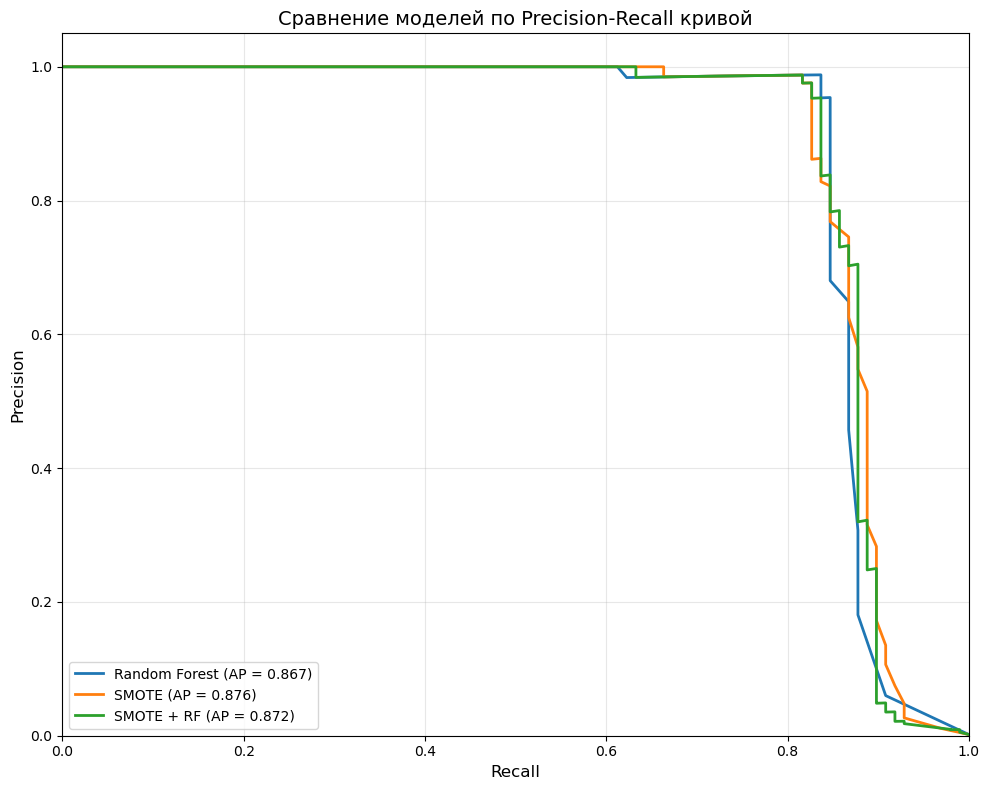

In [231]:
plt.figure(figsize=(10, 8))

baseline_precision = y_test.mean()

for model_name, y_proba in model_probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = auc(recall, precision)
    
    plt.plot(
        recall, 
        precision, 
        lw=2,
        label=f'{model_name} (AP = {average_precision:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Сравнение моделей по Precision-Recall кривой", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

**SMOTE** чуть лучше, но **SMOTE +RF** не сильно хуже 

**ADASYN + Random Forest**

In [30]:
def objective(trial):
    params = {
        'adasyn__n_neighbors': trial.suggest_int('adasyn__n_neighbors', 3, 10),
        'adasyn__sampling_strategy': trial.suggest_float('adasyn__sampling_strategy', 0.5, 1.0),
        
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 300),
        'model__max_depth': trial.suggest_int('model__max_depth', 5, 30),
        'model__class_weight': trial.suggest_categorical('model__class_weight', ['balanced', None])
    }
    
    pipeline = Pipeline([
        ('adasyn', ADASYN()),
        ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
    ]).set_params(**params)
    
    return cross_val_score(
        pipeline, 
        X_train, 
        y_train, 
        cv=kf, 
        scoring='f1',
        n_jobs=-1
    ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

adasyn_rf = Pipeline([
    ('adasyn', ADASYN()),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
]).set_params(**study.best_params)

[I 2025-05-02 12:31:26,008] A new study created in memory with name: no-name-7386c8d0-f9a0-4a8e-a1d3-2238370d0e51
[I 2025-05-02 12:38:09,765] Trial 0 finished with value: 0.728451905808712 and parameters: {'adasyn__n_neighbors': 3, 'adasyn__sampling_strategy': 0.5157569470265968, 'model__n_estimators': 220, 'model__max_depth': 21, 'model__class_weight': 'balanced'}. Best is trial 0 with value: 0.728451905808712.
[I 2025-05-02 12:45:06,674] Trial 1 finished with value: 0.7445198983400927 and parameters: {'adasyn__n_neighbors': 5, 'adasyn__sampling_strategy': 0.5348176171471841, 'model__n_estimators': 217, 'model__max_depth': 24, 'model__class_weight': 'balanced'}. Best is trial 1 with value: 0.7445198983400927.
[I 2025-05-02 12:51:49,681] Trial 2 finished with value: 0.15682152335346883 and parameters: {'adasyn__n_neighbors': 5, 'adasyn__sampling_strategy': 0.8516034692373273, 'model__n_estimators': 274, 'model__max_depth': 8, 'model__class_weight': 'balanced'}. Best is trial 1 with val

In [22]:
print(f"Лучшие параметры: adasyn__n_neighbors: 3, adasyn__sampling_strategy: 0.6321267035353013, model__n_estimators: 176, model__max_depth: 29, model__class_weight: None")

Лучшие параметры: adasyn__n_neighbors: 3, adasyn__sampling_strategy: 0.6321267035353013, model__n_estimators: 176, model__max_depth: 29, model__class_weight: None


In [70]:
params = {
    'adasyn__n_neighbors': 3,
    'adasyn__sampling_strategy': 0.6321267035353013,
    'randomforestclassifier__n_estimators': 176,
    'randomforestclassifier__max_depth': 29,
    'randomforestclassifier__class_weight': None
}

model = Pipeline([
    ('adasyn', ADASYN(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
]).set_params(**params)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='f1', n_jobs=-1)

print(f"Кросс-валидация F1 scores: {scores.round(4)}, Среднее: {scores.mean():.4f}")
print(f"Разброс: {scores.max() - scores.min():.4f}")

Кросс-валидация F1 scores: [0.8316 0.8969 0.8482 0.8324 0.8141], Среднее: 0.8446
Разброс: 0.0828


Модель при лучших параметрах **устойчива**.

In [34]:
start_train = time.perf_counter()
adasyn_rf.fit(X_train, y_train)
train_time_adasyn_rf = time.perf_counter() - start_train

prediction_adasyn_rf = adasyn_rf.predict(X_test)
y_proba = adasyn_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, prediction_adasyn_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.84 - модель ошибается в 16% случаев, предсказывая положительный класс.

* **Recall** = 0.83 - модель не видит 17% реальных положительных случаев.

* **F1-score** = 0.84

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

In [37]:
model_predictions = {
    "Random Forest": prediction_rf,
    "ADASYN": prediction_adasyn,
    "ADASYN + RF": prediction_adasyn_rf
}

train_times = {
    "Random Forest": train_time_rf,
    "ADASYN": train_time_adasyn,
    "ADASYN + RF": train_time_adasyn_rf
}

results = []

for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    metrics = {
        "Модель": model_name,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
        "Время обучения (с)": train_times[model_name]
    }
    
    results.append(metrics)

data_results_adasyn_rf = pd.DataFrame(results)
data_results_adasyn_rf

,Модель,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,Время обучения (с)
0,Random Forest,0.999701,0.999982,0.999842,0.987805,0.826531,0.900000,0.999684,168.529475
1,ADASYN,0.999701,0.999807,0.999754,0.880435,0.826531,0.852632,0.999508,319.087381
2,ADASYN + RF,0.999701,0.999736,0.999719,0.843750,0.826531,0.835052,0.999438,98.667587


**Выводы по работе моделей:**
1. Оптимизация прошла успешно за счёт снижения времени обучения почти в **2 раза** по сравнению с **Random Forest** и в **боллее 3 раза** по сравнинию с **ADASYN** методом
2. Оптимизированная модель устойчива

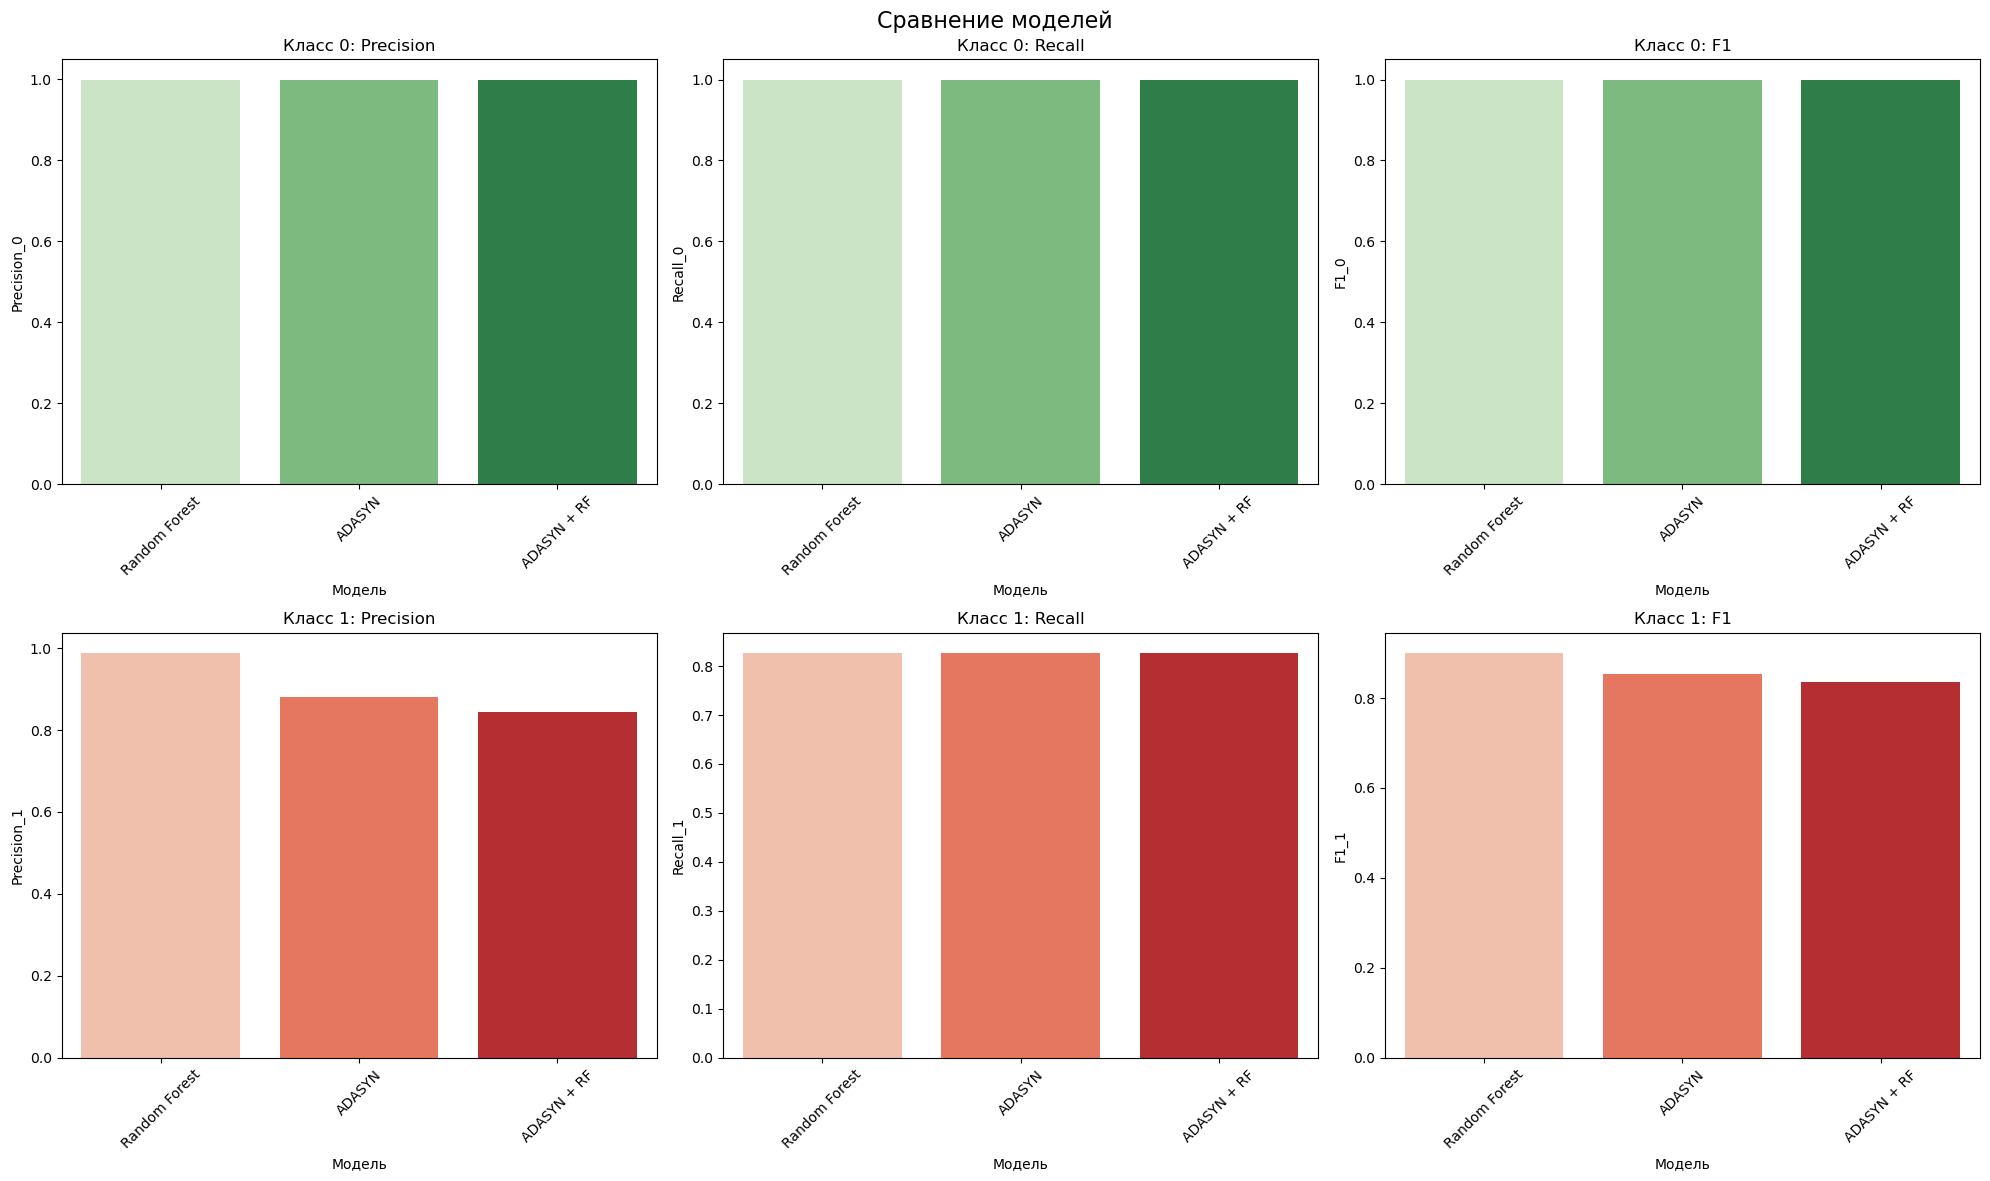

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Сравнение моделей', fontsize=16)

for i, metric in enumerate(['Precision_0', 'Recall_0', 'F1_0']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_adasyn_rf,
        ax=axes[0, i],
        palette='Greens'
    )
    axes[0, i].set_title(f'Класс 0: {metric.split("_")[0]}')
    axes[0, i].tick_params(axis='x', rotation=45)

for i, metric in enumerate(['Precision_1', 'Recall_1', 'F1_1']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_adasyn_rf,
        ax=axes[1, i],
        palette='Reds'
    )
    axes[1, i].set_title(f'Класс 1: {metric.split("_")[0]}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()

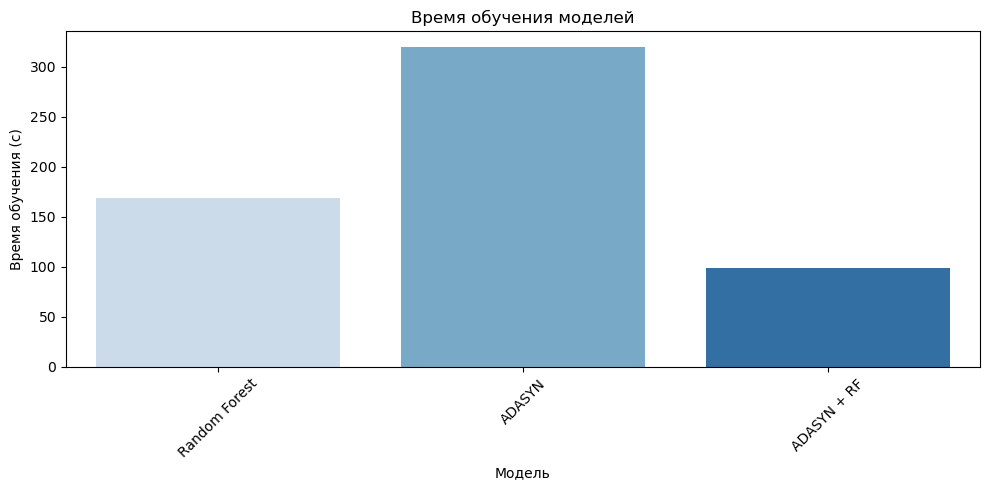

In [42]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Модель', 
    y='Время обучения (с)', 
    data=data_results_adasyn_rf,
    palette='Blues'
)
plt.title('Время обучения моделей')
plt.xticks(rotation=45)
plt.tight_layout()

Оптимизированная модель **самая быстрая**.

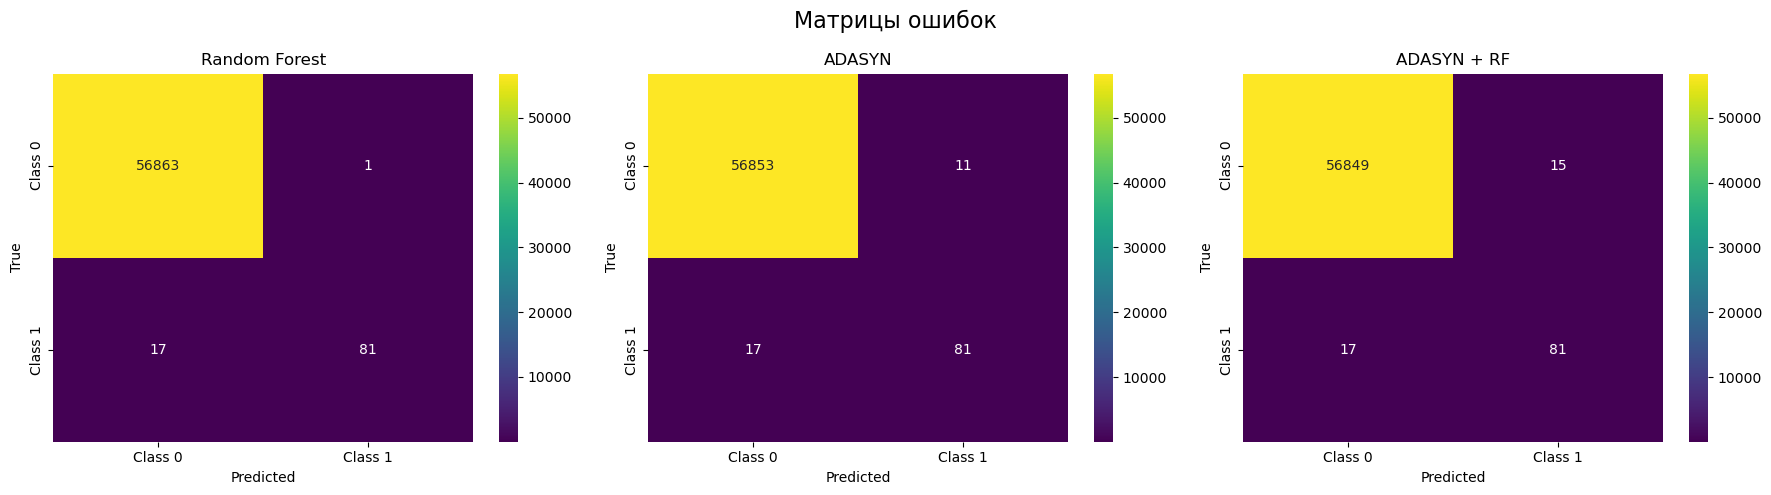

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Матрицы ошибок', fontsize=16)

for ax, (model_name, y_pred) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='viridis',
        ax=ax,
        xticklabels=['Class 0', 'Class 1'],
        yticklabels=['Class 0', 'Class 1']
    )
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

За счёт оптимизации и снижения времени обучения модель чаще стала неверно распознавать класс большинство (0).

In [46]:
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_adasyn = rf_model_adasyn.predict_proba(X_test)[:, 1]
y_proba_adasyn_rf = adasyn_rf.predict_proba(X_test)[:, 1]

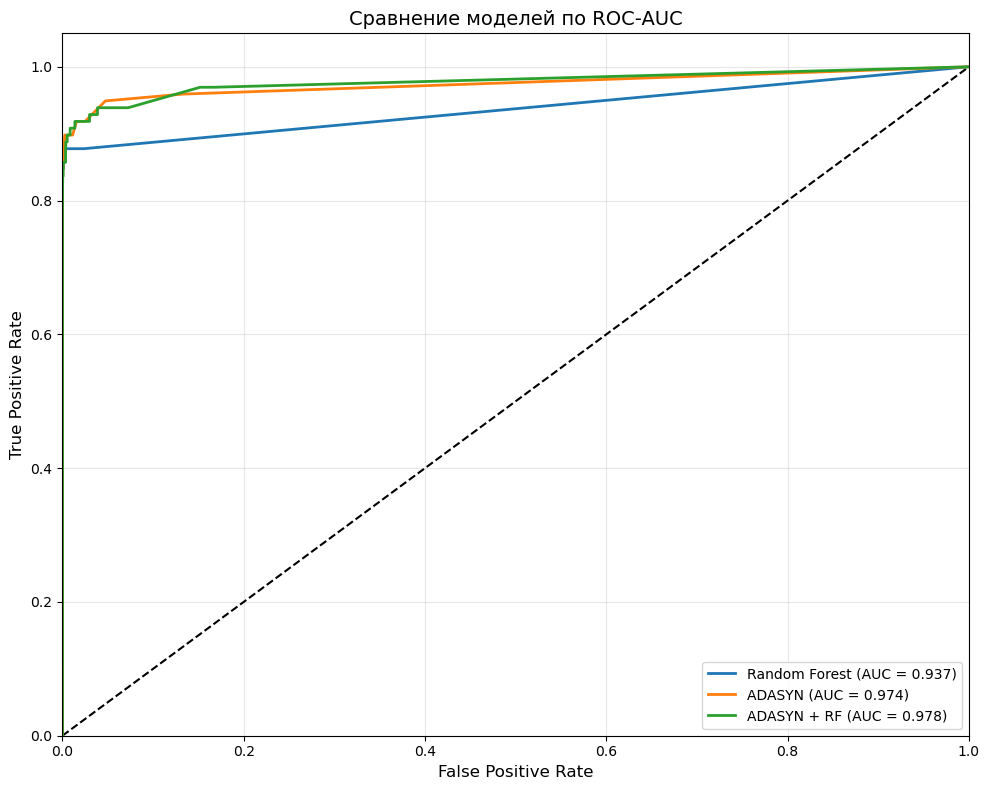

In [48]:
model_probabilities = {
    "Random Forest": y_proba_rf,
    "ADASYN": y_proba_adasyn,
    "ADASYN + RF": y_proba_adasyn_rf
}
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for model_name, y_proba in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(
        fpr, 
        tpr, 
        lw=2,
        label=f'{model_name} (AUC = {roc_auc:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Сравнение моделей по ROC-AUC", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Оптимизированная модель **лучше** остальных разделяет классы, так как у неё самая большая площадь под кривой из трёх представленных моделей.

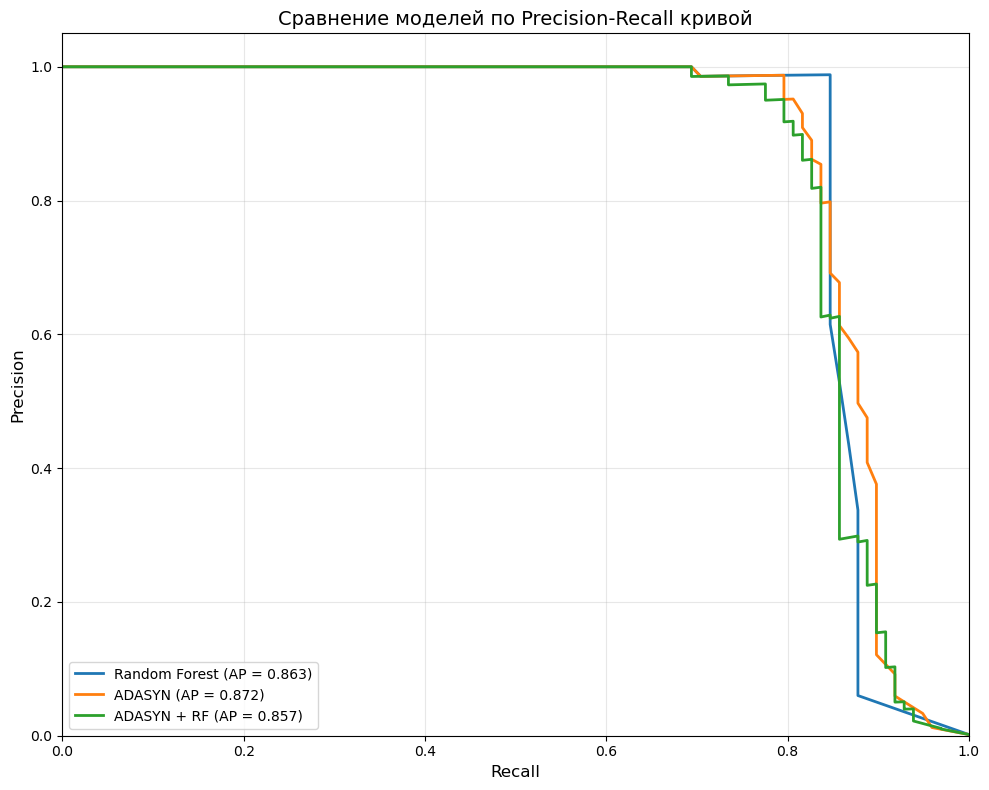

In [50]:
plt.figure(figsize=(10, 8))

baseline_precision = y_test.mean()

for model_name, y_proba in model_probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = auc(recall, precision)
    
    plt.plot(
        recall, 
        precision, 
        lw=2,
        label=f'{model_name} (AP = {average_precision:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Сравнение моделей по Precision-Recall кривой", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Все 3 модели хорошие, и правильно определяют классы.

**Tomek Links + Random Forest**

In [52]:
def objective(trial):
    params = {
        'tomek__sampling_strategy': trial.suggest_categorical(
            'tomek__sampling_strategy', 
            ['majority', 'not minority', 'all']
        ),
        
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 300),
        'model__max_depth': trial.suggest_int('model__max_depth', 5, 30),
        'model__class_weight': trial.suggest_categorical('model__class_weight', ['balanced', None])
    }
    
    pipeline = Pipeline([
        ('tomek', TomekLinks()),
        ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
    ]).set_params(**params)
    
    return cross_val_score(
        pipeline, 
        X_train, 
        y_train, 
        cv=kf, 
        scoring='f1',
        n_jobs=-1
    ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

tomek_rf = Pipeline([
    ('tomek', TomekLinks()),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=42))
]).set_params(**study.best_params)

[I 2025-05-02 14:23:54,345] A new study created in memory with name: no-name-6cfe258d-687d-43e7-8203-00cf4b1fd9d6
[I 2025-05-02 14:32:54,864] Trial 0 finished with value: 0.8365252334661882 and parameters: {'tomek__sampling_strategy': 'majority', 'model__n_estimators': 202, 'model__max_depth': 28, 'model__class_weight': None}. Best is trial 0 with value: 0.8365252334661882.
[I 2025-05-02 14:49:44,378] Trial 1 finished with value: 0.838900698999565 and parameters: {'tomek__sampling_strategy': 'all', 'model__n_estimators': 242, 'model__max_depth': 28, 'model__class_weight': None}. Best is trial 1 with value: 0.838900698999565.
[I 2025-05-02 14:55:26,910] Trial 2 finished with value: 0.8381504809244241 and parameters: {'tomek__sampling_strategy': 'not minority', 'model__n_estimators': 100, 'model__max_depth': 30, 'model__class_weight': None}. Best is trial 1 with value: 0.838900698999565.
[I 2025-05-02 15:03:15,623] Trial 3 finished with value: 0.8365693079146798 and parameters: {'tomek__

In [86]:
print(f"Лучшие параметры: tomek__sampling_strategy: all, model__n_estimators: 242, model__max_depth: 28, model__class_weight: None")

Лучшие параметры: tomek__sampling_strategy: all, model__n_estimators: 242, model__max_depth: 28, model__class_weight: None


In [194]:
params = {
    'tomek__sampling_strategy': 'all',
    'randomforestclassifier__n_estimators': 242,
    'randomforestclassifier__max_depth': 28,
    'randomforestclassifier__class_weight': None
}

model = Pipeline([
    ('tomek', TomekLinks()),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
]).set_params(**params)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='f1', n_jobs=-1)

print(f"Кросс-валидация F1 scores: {scores.round(4)}, Среднее: {scores.mean():.4f}")
print(f"Разброс: {scores.max() - scores.min():.4f}")

Кросс-валидация F1 scores: [0.8398 0.8652 0.8715 0.8588 0.8508], Среднее: 0.8572
Разброс: 0.0317


Модель при лучших параметрах **устойчива**.

In [53]:
start_train = time.perf_counter()
tomek_rf.fit(X_train, y_train)
train_time_tomek_rf = time.perf_counter() - start_train

prediction_tomek_rf = tomek_rf.predict(X_test)
y_proba = tomek_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, prediction_tomek_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.84      0.91        98

    accuracy                           1.00     56962
   macro avg       0.99      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.

Для класса меньшинства (1):

* **Precision** = 0.99 - модель ошибается в 1% случаев, предсказывая положительный класс.

* **Recall** = 0.84 - модель не видит 16% реальных положительных случаев.

* **F1-score** = 0.91

**Accuracy** равен 1.00, но это неправильно, так как основной вклад вносит класс большинства (0).

In [60]:
model_predictions = {
    "Random Forest": prediction_rf,
    "Tomek Links": prediction_tomek,
    "Tomek Links + RF": prediction_tomek_rf
}

train_times = {
    "Random Forest": train_time_rf,
    "Tomek Links": train_time_tomek,
    "Tomek Links + RF": train_time_tomek_rf
}

results = []

for model_name, y_pred in model_predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    metrics = {
        "Модель": model_name,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
        "Время обучения (с)": train_times[model_name]
    }
    
    results.append(metrics)

data_results_tomek_rf = pd.DataFrame(results)
data_results_tomek_rf

,Модель,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,Время обучения (с)
0,Random Forest,0.999701,0.999982,0.999842,0.987805,0.826531,0.900000,0.999684,168.529475
1,Tomek Links,0.999719,0.999982,0.999851,0.987952,0.836735,0.906077,0.999702,163.284004
2,Tomek Links + RF,0.999719,0.999982,0.999851,0.987952,0.836735,0.906077,0.999702,158.072725


**Выводы по работе моделей:**
1. Оптимизация прошла успешно за счёт снижения времени обучения
2. Оптимизированная модель устойчива
3. **Precision_1, Recall_1, F1_1** стабильно высокие

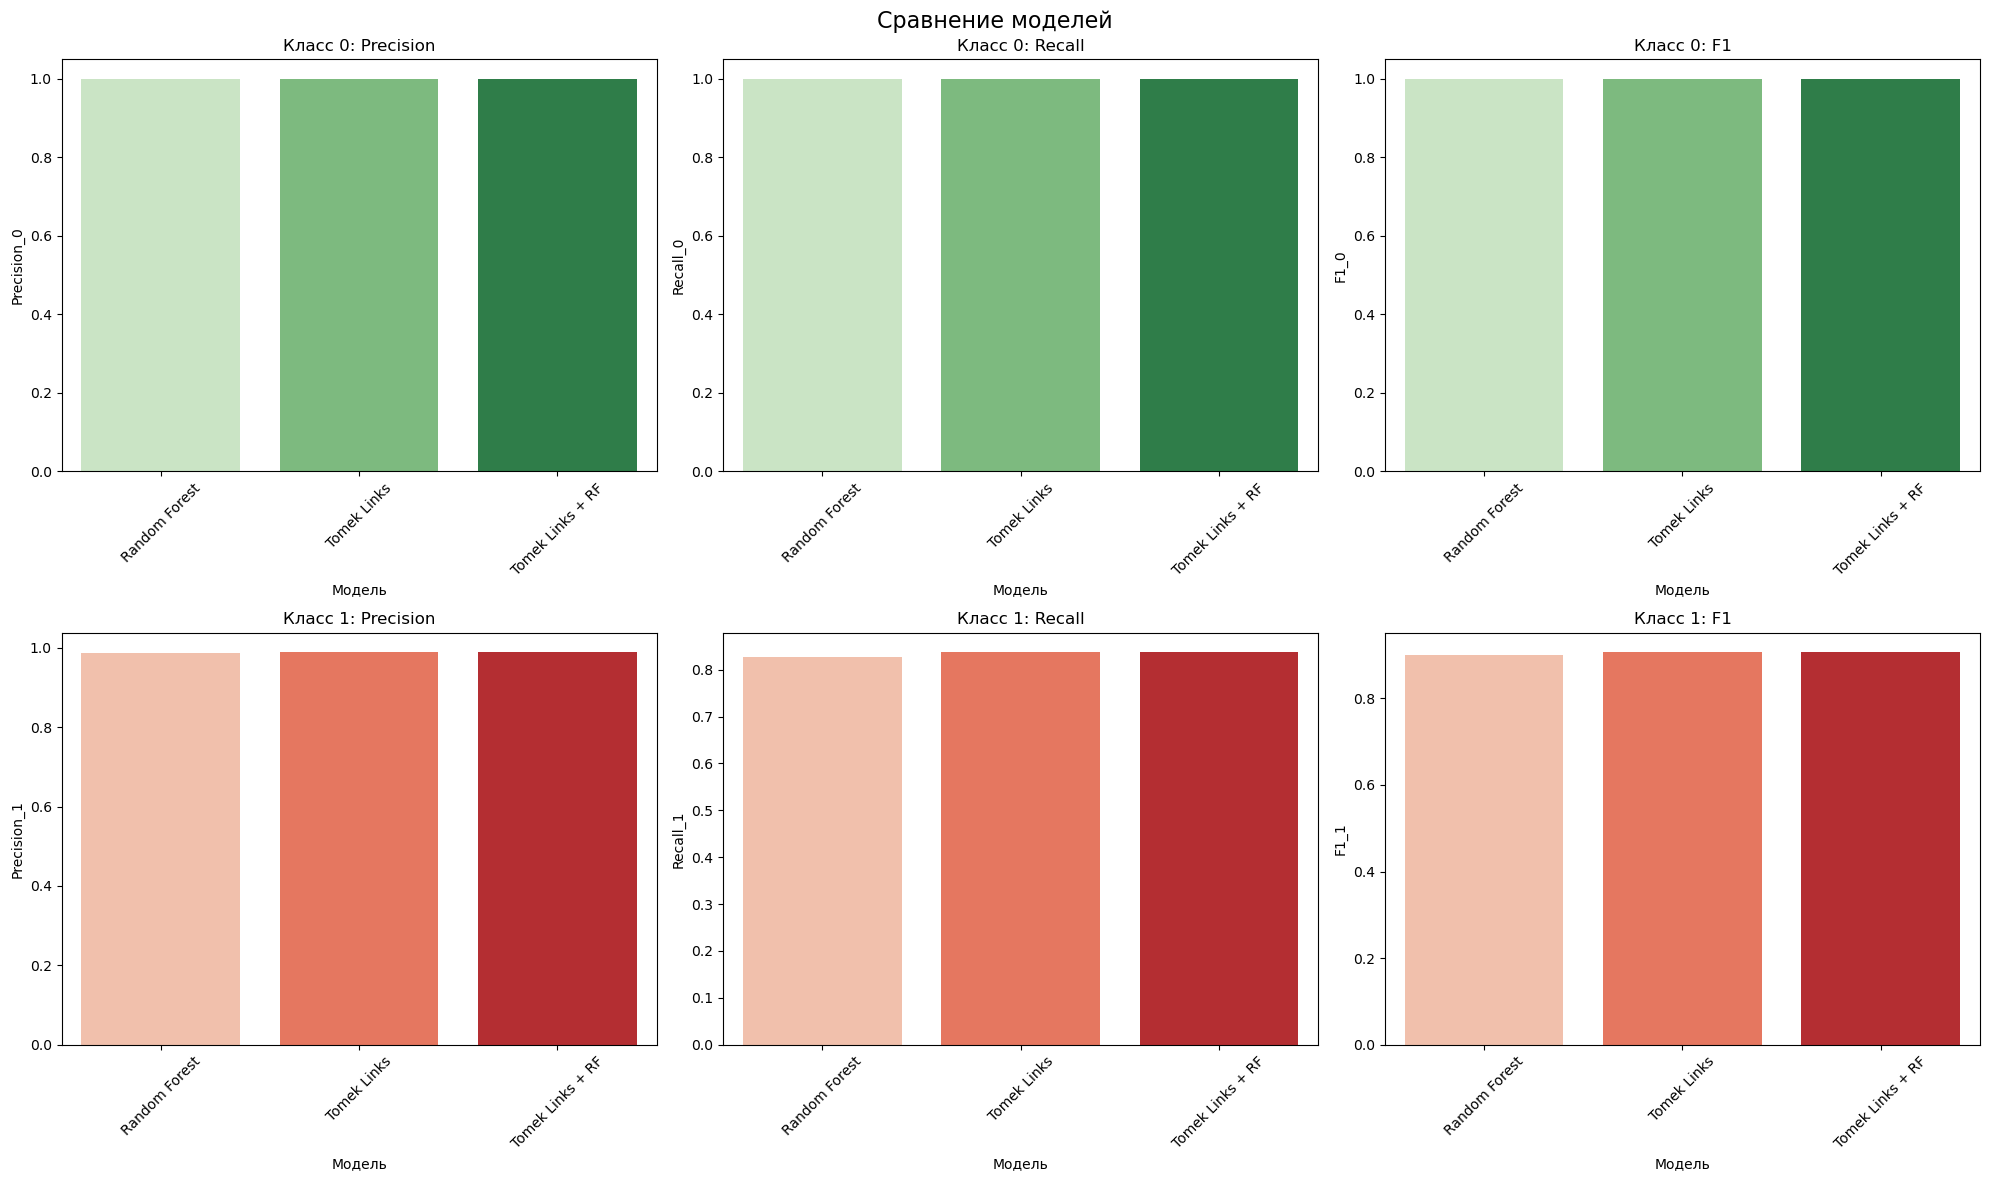

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Сравнение моделей', fontsize=16)

for i, metric in enumerate(['Precision_0', 'Recall_0', 'F1_0']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_tomek_rf,
        ax=axes[0, i],
        palette='Greens'
    )
    axes[0, i].set_title(f'Класс 0: {metric.split("_")[0]}')
    axes[0, i].tick_params(axis='x', rotation=45)

for i, metric in enumerate(['Precision_1', 'Recall_1', 'F1_1']):
    sns.barplot(
        x='Модель', 
        y=metric, 
        data=data_results_tomek_rf,
        ax=axes[1, i],
        palette='Reds'
    )
    axes[1, i].set_title(f'Класс 1: {metric.split("_")[0]}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()

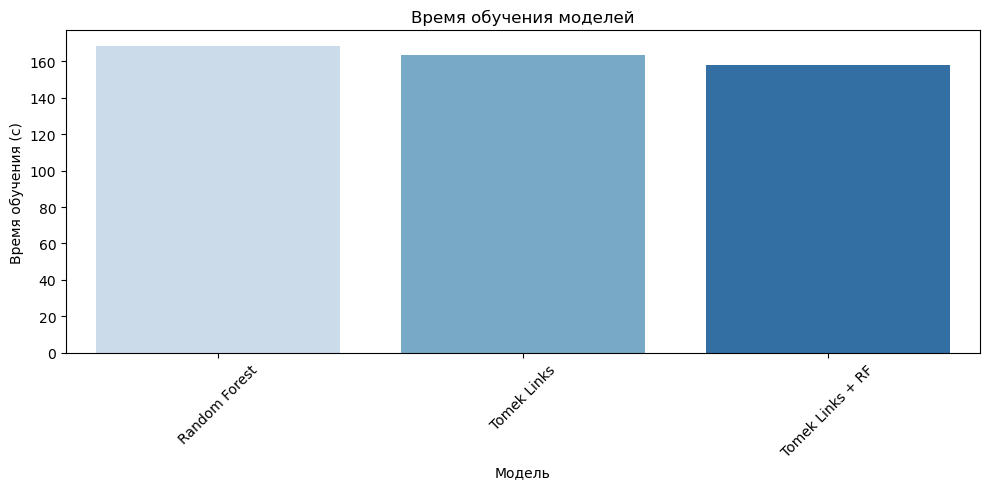

In [64]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Модель', 
    y='Время обучения (с)', 
    data=data_results_tomek_rf,
    palette='Blues'
)
plt.title('Время обучения моделей')
plt.xticks(rotation=45)
plt.tight_layout()

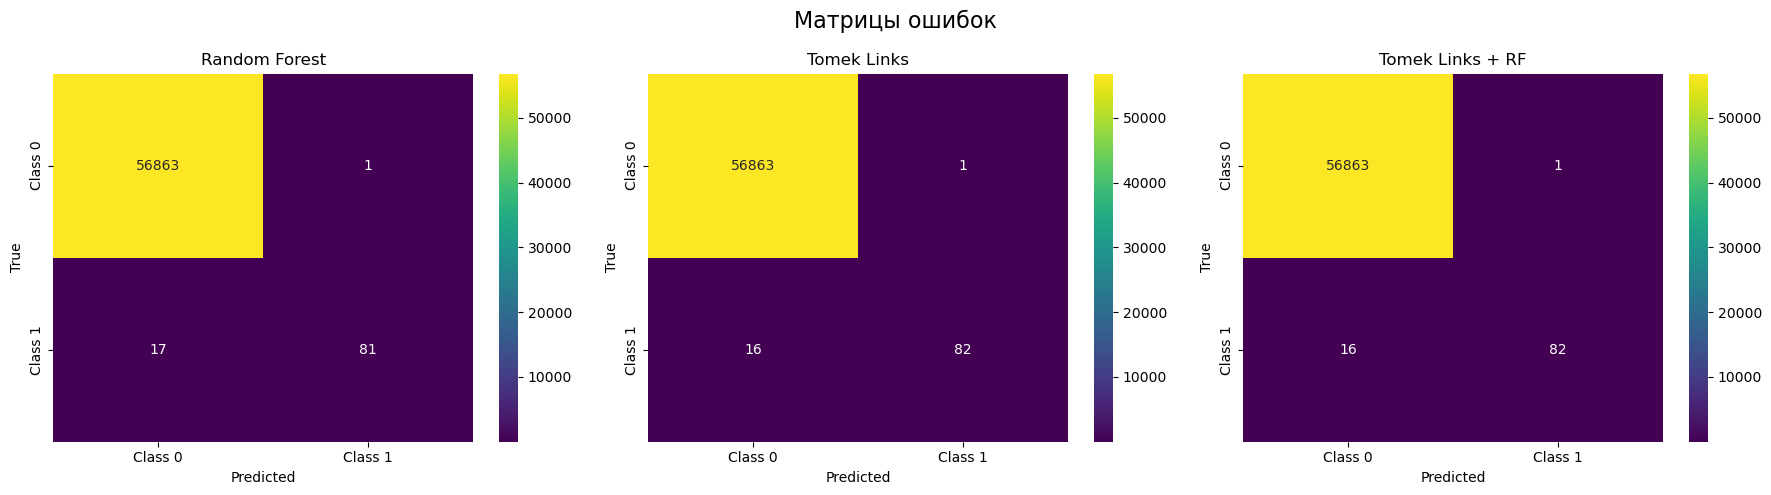

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Матрицы ошибок', fontsize=16)

for ax, (model_name, y_pred) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='viridis',
        ax=ax,
        xticklabels=['Class 0', 'Class 1'],
        yticklabels=['Class 0', 'Class 1']
    )
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

Примениние **Tomek Links** позволило увеличить распознавние класса меньшинства (1), а оптимизация позволила это делать чуть быстрее.

In [68]:
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_tomek = rf_model_tomek.predict_proba(X_test)[:, 1]
y_proba_tomek_rf = tomek_rf.predict_proba(X_test)[:, 1]

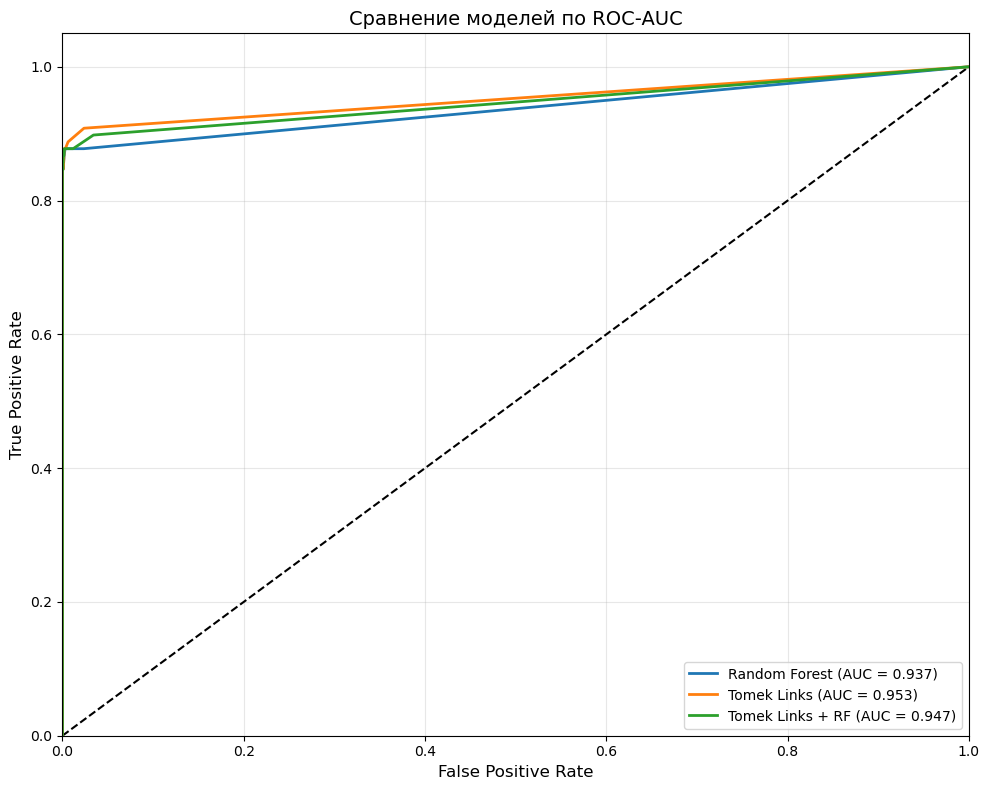

In [70]:
model_probabilities = {
    "Random Forest": y_proba_rf,
    "Tomek Links": y_proba_tomek,
    "Tomek Links + RF": y_proba_tomek_rf
}
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for model_name, y_proba in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(
        fpr, 
        tpr, 
        lw=2,
        label=f'{model_name} (AUC = {roc_auc:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Сравнение моделей по ROC-AUC", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Все три модели хорошо разделяют классы, но **Tomek Links** и оптимизированная модель делают это лучше.

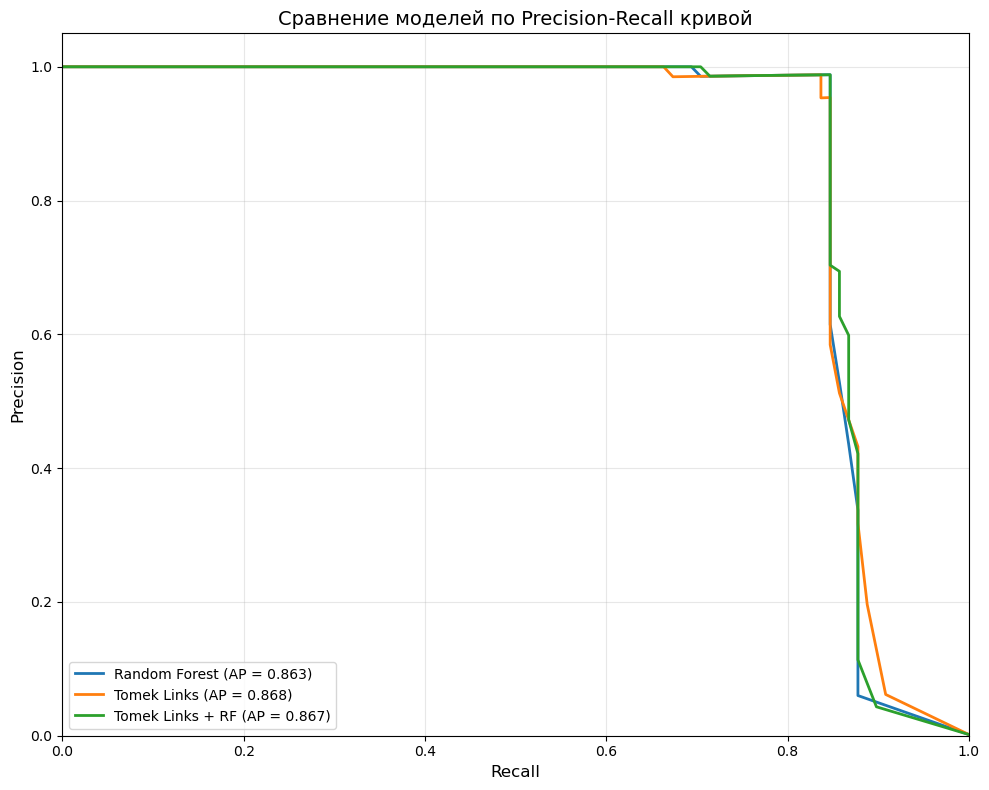

In [72]:
plt.figure(figsize=(10, 8))

baseline_precision = y_test.mean()

for model_name, y_proba in model_probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    average_precision = auc(recall, precision)
    
    plt.plot(
        recall, 
        precision, 
        lw=2,
        label=f'{model_name} (AP = {average_precision:.3f})'
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Сравнение моделей по Precision-Recall кривой", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Все 3 модели хорошо определяют классы.

# **Выводы**

In [104]:
data_option = {
    "Random Forest": {
        "Precision_0": 0.999701, "Recall_0": 0.999982, "F1_0": 0.999842,
        "Precision_1": 0.987805, "Recall_1": 0.826531, "F1_1": 0.900000,
        "Accuracy": 0.999684, "Время обучения (с)": 163.212322
    },
    "SMOTE": {
        "Precision_0": 0.999701, "Recall_0": 0.999824, "F1_0": 0.999763,
        "Precision_1": 0.890110, "Recall_1": 0.826531, "F1_1": 0.857143,
        "Accuracy": 0.999526, "Время обучения (с)": 284.869068
    },
    "SMOTE + RF": {
        "Precision_0": 0.999719, "Recall_0": 0.999859, "F1_0": 0.999789,
        "Precision_1": 0.911111, "Recall_1": 0.836735, "F1_1": 0.872340,
        "Accuracy": 0.999579, "Время обучения (с)": 86.084140
    },
    "ADASYN": {
        "Precision_0": 0.999701, "Recall_0": 0.999807, "F1_0": 0.999754,
        "Precision_1": 0.880435, "Recall_1": 0.826531, "F1_1": 0.852632,
        "Accuracy": 0.999508, "Время обучения (с)": 319.087381
    },
    "ADASYN + RF": {
        "Precision_0": 0.999701, "Recall_0": 0.999736, "F1_0": 0.999719,
        "Precision_1": 0.843750, "Recall_1": 0.826531, "F1_1": 0.835052,
        "Accuracy": 0.999438, "Время обучения (с)": 98.667587
    },
    "Tomek Links": {
        "Precision_0": 0.999719, "Recall_0": 0.999982, "F1_0": 0.999851,
        "Precision_1": 0.987952, "Recall_1": 0.836735, "F1_1": 0.906077,
        "Accuracy": 0.999702, "Время обучения (с)": 163.284004
    },
    "Tomek Links + RF": {
        "Precision_0": 0.999719, "Recall_0": 0.999982, "F1_0": 0.999851,
        "Precision_1": 0.987952, "Recall_1": 0.836735, "F1_1": 0.906077,
        "Accuracy": 0.999702, "Время обучения (с)": 158.072725
    }
}

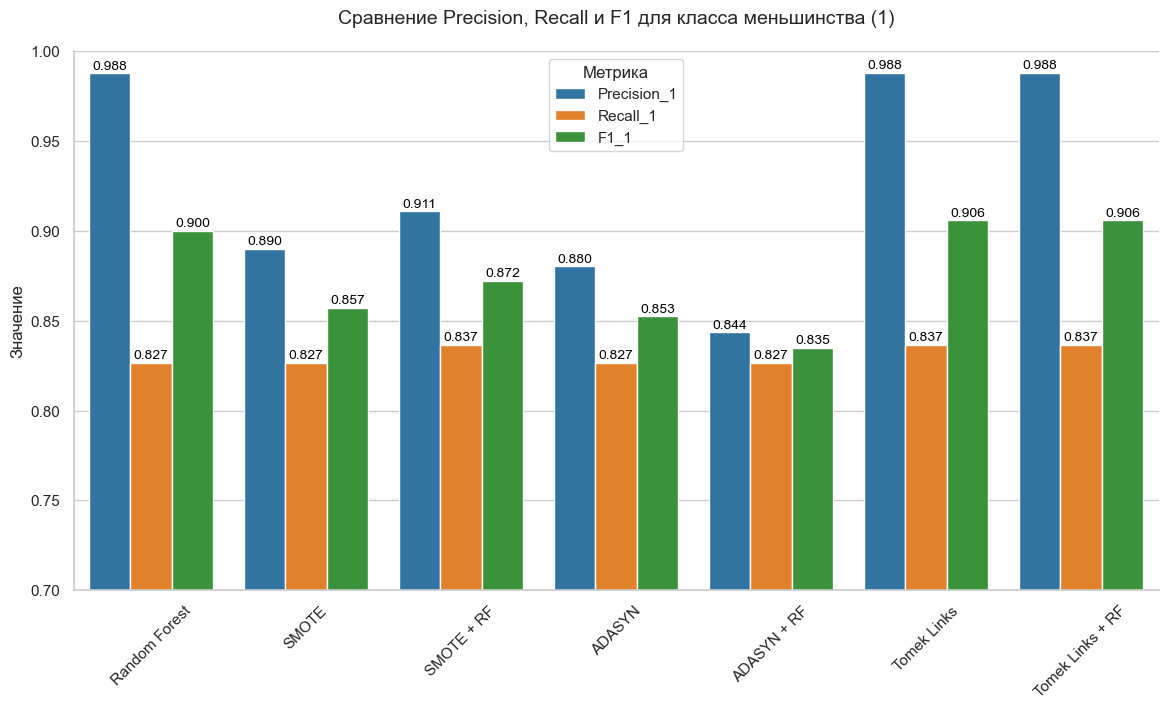

In [195]:
df = pd.DataFrame(data_option).T.reset_index().rename(columns={"index": "Модель"})
df_melted = df.melt(id_vars="Модель", value_vars=["Precision_1", "Recall_1", "F1_1"], var_name="Metric")

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_melted, x="Модель", y="value", hue="Metric", palette="tab10")

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        fontsize=10, color='black',
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title("Сравнение Precision, Recall и F1 для класса меньшинства (1)", fontsize=14, pad=20)
plt.ylabel("Значение", fontsize=12)
plt.xlabel("")
plt.ylim(0.7, 1.0)
plt.legend(title="Метрика", frameon=True)
plt.xticks(rotation=45)
sns.despine()
plt.show()

**Выводы**

1. Провведён описательный анализ датасета (EDA).
2. Проведена предварительную обработка данных (Preprocessing DATA). 'Amount' и 'Time' предобработаны.
3. Разделены данные на обучающую и тестовую выборки по формуле 80 на 20. Произведена кросс-валидация.
4. Обучена и выбрана лучшая модель машинного обучения без применения методов борьбы с перекосом классов. Этой моделью стала Random Forest.
5. Применены методы борьбы с перекосом классов для выбранной модели. Тремя лучшими методами стали модели SMOTE, ADASYN и TOMEK LINKS. Они оптимизированы через Optuna.

7. Самой **лучшей моделью** стала **Tomek Links**:
           Для класса большинства (0) метрики (**precision, recall, F1**) равны 1.00, это значит идеальное распознавание этого класса.
           Для класса меньшинства (1):
           **Precision** = 0.99 - модель ошибается в 1% случаев, предсказывая положительный класс.
           **Recall** = 0.84 - модель не видит 16% реальных положительных случаев.
           **F1-score** = 0.91
8. Модель будет пропускать всего 16 % процентов мошеннических транзакций. При этом 99% из обнаруженных подозрительных операций являются мошенническими. Обычные операции определяются почти в 100% случаев.

Всё!